In [1]:
%matplotlib inline

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import os
import matplotlib.pyplot as plt
from osgeo import gdal, osr
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib 
import datetime
import numpy as np
import pandas as pd
import matplotlib as mpl
import sys, os, re

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)
c = mcolors.ColorConverter().to_rgb

In [4]:
# Colors via http://colorbrewer2.com/
WHITE, LIGHT_GRAY, GRAY, BLACK = [ "#FFFFFF", "#E5E5E5", "#777777", "#000000" ] 
COLORS = [ "#FF6600", "#D7191C", "#2C7BB6", "#FFFFBF", "#ABD9E9" ]
COLORS2 = [ "#ffaa00", "#e6e600", "#ffff73", "#9fa7c9", "#305fcf" ]
COLORS3 = [ "#ffff64", "#286400", "#9ac800", "#ffb432"]
ORANGE, RED, BLUE, YELLOW, LIGHT_BLUE = COLORS
HIGH_ALPHA = 0.9
MEDIUM_ALPHA = 0.5
LOW_ALPHA = 0.1
rgba = mpl.colors.colorConverter.to_rgba

def set_styles(style_dict):
    """Set matplotlib styles from nested a nested dictionary"""
    for obj in style_dict: mpl.rc(obj, **style_dict[obj]) 

set_styles({
    "figure": { "figsize": [ 12, 8 ], "facecolor": WHITE },
    "savefig": { "dpi": 200, "bbox": "tight" },
    "patch": { "linewidth": 0.5, "facecolor": ORANGE, "edgecolor": BLACK, "antialiased": True },
    "font": { "size": 10 },
    "legend": { "fontsize": 10 },
    "axes": { 
        "facecolor": WHITE, 
        "edgecolor": BLACK, 
        "linewidth": 0.5, 
        "grid": False, 
        "titlesize": "large", 
        "labelsize": "large", 
        "labelcolor": BLACK,
        "axisbelow": True,
        "color_cycle": COLORS2
    },
    "xtick": { "color": BLACK, "direction": "out" },
    "ytick": { "color": BLACK, "direction": "out" },
    "grid": { "color": LIGHT_GRAY, "linestyle": "-" }
})

In [5]:
# (C) British Crown Copyright 2011 - 2012, Met Office
#
# This file is part of cartopy.
#
# cartopy is free software: you can redistribute it and/or modify it under
# the terms of the GNU Lesser General Public License as published by the
# Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# cartopy is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU Lesser General Public License for more details.
#
# You should have received a copy of the GNU Lesser General Public License
# along with cartopy.  If not, see <http://www.gnu.org/licenses/>.
"""
This module defines :class:`Feature` instances, for use with
ax.add_feature().

"""
from abc import ABCMeta, abstractmethod
import os.path

import numpy as np
import shapely.geometry

import cartopy.io.shapereader as shapereader
import cartopy.crs


COLORS = {'land': np.array((240, 240, 220)) / 256.,
          'land_alt1': np.array((220, 220, 220)) / 256.,
          'water': np.array((152, 183, 226)) / 256.}
"""
A dictionary of colors useful for drawing Features.

The named keys in this dictionary represent the "type" of
feature being plotted.

"""


_NATURAL_EARTH_GEOM_CACHE = {}
"""
Caches a mapping between (name, category, scale) and a tuple of the
resulting geometries.

Provides a significant performance benefit (when combined with object id
caching in GeoAxes.add_geometries) when producing multiple maps of the
same projection.

"""


class Feature(object):
    """
    Represents a collection of points, lines and polygons with convenience
    methods for common drawing and filtering operations.

    Args:

        * crs - the coordinate reference system of this Feature

    Kwargs:
        Keyword arguments to be used when drawing this feature.

    .. seealso::

        To add features to the current matplotlib axes, see
        :func:`GeoAxes <cartopy.mpl.geoaxes.GeoAxes.add_feature>`.

    """
    __metaclass__ = ABCMeta

    def __init__(self, crs, **kwargs):
        self._crs = crs
        self._kwargs = dict(kwargs)

    @property
    def crs(self):
        """The cartopy CRS for the geometries in this feature."""
        return self._crs

    @property
    def kwargs(self):
        """
        The read-only dictionary of keyword arguments that are used when
        creating the matplotlib artists for this feature.

        """
        return dict(self._kwargs)

    @abstractmethod
    def geometries(self):
        """
        Returns an iterator of (shapely) geometries for this feature.

        """
        pass

    def intersecting_geometries(self, extent):
        """
        Returns an iterator of shapely geometries that intersect with
        the given extent. The extent is assumed to be in the CRS of
        the feature. If extent is None, the method returns all
        geometries for this dataset.

        """
        if extent is not None:
            extent_geom = shapely.geometry.box(extent[0], extent[2],
                                               extent[1], extent[3])
            return (geom for geom in self.geometries() if
                    extent_geom.intersects(geom))
        else:
            return self.geometries()


class ShapelyFeature(Feature):
    """
    A class capable of drawing a collection of
    shapely geometries.

    """
    def __init__(self, geometries, crs, **kwargs):
        """
        Args:

        * geometries:
            A collection of shapely geometries.
        * crs:
            The cartopy CRS in which the provided geometries are defined.

        Kwargs:
            Keyword arguments to be used when drawing this feature.

        """
        super(ShapelyFeature, self).__init__(crs, **kwargs)
        self._geoms = tuple(geometries)

    def geometries(self):
        return iter(self._geoms)


class NaturalEarthFeature(Feature):
    """
    A simple interface to Natural Earth shapefiles.

    See http://www.naturalearthdata.com/

    """
    def __init__(self, category, name, scale, **kwargs):
        """
        Args:

        * category:
            The category of the dataset, i.e. either 'cultural' or 'physical'.
        * name:
            The name of the dataset, e.g. 'admin_0_boundary_lines_land'.
        * scale:
            The dataset scale, i.e. one of '10m', '50m', or '110m'.
            Corresponding to 1:10,000,000, 1:50,000,000, and 1:110,000,000
            respectively.

        Kwargs:
            Keyword arguments to be used when drawing this feature.

        """
        super(NaturalEarthFeature, self).__init__(cartopy.crs.PlateCarree(),
                                                  **kwargs)
        self.category = category
        self.name = name
        self.scale = scale

    def geometries(self):
        key = (self.name, self.category, self.scale)
        if key not in _NATURAL_EARTH_GEOM_CACHE:
            path = shapereader.natural_earth(resolution=self.scale,
                                             category=self.category,
                                             name=self.name)
            geometries = tuple(shapereader.Reader(path).geometries())
            _NATURAL_EARTH_GEOM_CACHE[key] = geometries
        else:
            geometries = _NATURAL_EARTH_GEOM_CACHE[key]

        return iter(geometries)


class GSHHSFeature(Feature):
    """
    An interface to the GSHHS dataset.

    See http://www.ngdc.noaa.gov/mgg/shorelines/gshhs.html

    Args:

    * scale:
        The dataset scale. One of 'auto', 'coarse', 'low', 'intermediate',
        'high, or 'full' (default is 'auto').
    * levels:
        A list of integers 1-4 corresponding to the desired GSHHS feature
        levels to draw (default is [1] which corresponds to coastlines).

    Kwargs:
        Keyword arguments to be used when drawing the feature. Defaults
        are edgecolor='black' and facecolor='none'.

    """

    _geometries_cache = {}
    """
    A mapping from scale and level to GSHHS shapely geometry::

        {(scale, level): geom}

    This provides a perfomance boost when plotting in interactive mode or
    instantiating multiple GSHHS artists, by reducing repeated file IO.

    """
    def __init__(self, scale='auto', levels=None, **kwargs):
        super(GSHHSFeature, self).__init__(cartopy.crs.PlateCarree(), **kwargs)

        if scale not in ('auto', 'a', 'coarse', 'c', 'low', 'l',
                         'intermediate', 'i', 'high', 'h', 'full', 'f'):
            raise ValueError("Unknown GSHHS scale '{}'.".format(scale))
        self._scale = scale

        if levels is None:
            levels = [1]
        self._levels = set(levels)
        unknown_levels = self._levels.difference([1, 2, 3, 4])
        if unknown_levels:
            raise ValueError("Unknown GSHHS levels "
                             "'{}'.".format(unknown_levels))

        # Default kwargs
        self._kwargs.setdefault('edgecolor', 'black')
        self._kwargs.setdefault('facecolor', 'none')

    def _scale_from_extent(self, extent):
        """
        Returns the appropriate scale (e.g. 'i') for the given extent
        expressed in PlateCarree CRS.

        """
        # Default to coarse scale
        scale = 'c'

        if extent is not None:
            # Upper limit on extent in degrees.
            scale_limits = (('c', 20.0),
                            ('l', 10.0),
                            ('i', 2.0),
                            ('h', 0.5),
                            ('f', 0.1))

            width = abs(extent[1] - extent[0])
            height = abs(extent[3] - extent[2])
            min_extent = min(width, height)
            if min_extent != 0:
                for scale, limit in scale_limits:
                    if min_extent > limit:
                        break

        return scale

    def geometries(self):
        return self.intersecting_geometries(extent=None)

    def intersecting_geometries(self, extent):
        if self._scale == 'auto':
            scale = self._scale_from_extent(extent)
        else:
            scale = self._scale[0]

        if extent is not None:
            extent_geom = shapely.geometry.box(extent[0], extent[2],
                                               extent[1], extent[3])
        for level in self._levels:
            geoms = GSHHSFeature._geometries_cache.get((scale, level))
            if geoms is None:
                # Load GSHHS geometries from appropriate shape file.
                # TODO selective load based on bbox of each geom in file.
                path = shapereader.gshhs(scale, level)
                geoms = tuple(shapereader.Reader(path).geometries())
                GSHHSFeature._geometries_cache[(scale, level)] = geoms
            for geom in geoms:
                if extent is None or extent_geom.intersects(geom):
                    yield geom


BORDERS = NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land',
                              '10m', edgecolor='black', facecolor='none')
"""Small scale (1:110m) country boundaries."""


COASTLINE = NaturalEarthFeature('physical', 'coastline', '10m',
                                edgecolor='black', facecolor='none')
"""Small scale (1:110m) coastline, including major islands."""


LAKES = NaturalEarthFeature('physical', 'lakes', '10m',
                            edgecolor='face',
                            facecolor=COLORS['water'])
"""Small scale (1:110m) natural and artificial lakes."""


LAND = NaturalEarthFeature('physical', 'land', '10m',
                           edgecolor='face',
                           facecolor=COLORS['land'])
"""Small scale (1:110m) land polygons, including major islands."""


OCEAN = NaturalEarthFeature('physical', 'ocean', '10m',
                            edgecolor='face',
                            facecolor=COLORS['water'])
"""Small scale (1:110m) ocean polygons."""


RIVERS = NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m',
                             edgecolor=COLORS['water'],
                             facecolor='none')
"""Small scale (1:110m) single-line drainages, including lake centerlines."""

'Small scale (1:110m) single-line drainages, including lake centerlines.'

In [6]:
def listall(RootFolder, varname=''):
    lists = [os.path.join(root, name)    
                 for root, dirs, files in os.walk(RootFolder)
                   for name in files
                   if varname in name
                     if name.endswith('.tif')]
    return lists

def setMap(rasterBase):

    # Read the data and metadata
    ds = gdal.Open(rasterBase)
    #band = ds.GetRasterBand(20)
    
    data = ds.ReadAsArray()
    gt = ds.GetGeoTransform()
    proj = ds.GetProjection()
    
    nan = ds.GetRasterBand(1).GetNoDataValue()
    if nan != None:
        data = np.ma.masked_equal(data,value=nan)
    
    xres = gt[1]
    yres = gt[5]
    
    # get the edge coordinates and add half the resolution 
    # to go to center coordinates
    xmin = gt[0] + xres * 0.5
    xmax = gt[0] + (xres * ds.RasterXSize) - xres * 0.5
    ymin = gt[3] + (yres * ds.RasterYSize) + yres * 0.5
    ymax = gt[3] - yres * 0.5
    
    x = ds.RasterXSize 
    y = ds.RasterYSize  
    extent = [ gt[0],gt[0]+x*gt[1], gt[3],gt[3]+y*gt[5]]
    #ds = None
    
    # create a grid of xy coordinates in the original projection
    xy_source = np.mgrid[xmin:xmax+xres:xres, ymax+yres:ymin:yres]
    
    return extent, xy_source, proj

In [19]:
folder_2010 = r'D:\Data\0_DAILY_INTERVAL_NDVI_TRMM\Jiujang\OUTPUT_2010//'#r'G:\New folder\AWC_CLASS2\phase//'
folder_2007 = r'D:\Data\0_DAILY_INTERVAL_NDVI_TRMM\Jiujang\OUTPUT_2007//'#r'G:\New folder\AWC_CLASS2\phase//'
#folde2 = r'G:\New folder\AWC_CLASS2\phase\PNG//'

PH2009

In [20]:
phase2010 = folder_2010+'ph12.tif' # 2010
print (phase2010)

#RasterFolder = r'D:\Data\0_DAILY_INTERVAL_NDVI_TRMM\Chongqing\TRMM\XVDaySums_15_NormAnomaly'
#raster = listall(RasterFolder)
rasterBase = phase2010#raster[0]

extent, xy_source, proj = setMap(phase2010)
extent

ds = gdal.Open(rasterBase)
array = ds.ReadAsArray()
band = ds.GetRasterBand(1)
nan = band.GetNoDataValue()
#nan = -99999.0
print (nan)
#img = np.flipud(array)

img_extent = (extent[0], extent[1], extent[2], extent[3])
set_extent = [extent[0], extent[1], extent[2], extent[3]]

#path_NDVI = r'D:\Data\0_DAILY_INTERVAL_NDVI_TRMM\Jiujang\NDVI2010_DryYear\10_Day_Period\10_DaySums_StdNormAnomalyClip//NDVI_IM_2010001.tif'
#ds_ndvi = gdal.Open(path_NDVI).ReadAsArray()
#ds_ndvi[0][0]

ds09 = gdal.Open(phase2010)
array09 = ds09.ReadAsArray()
array09 = np.ma.masked_where(array09 == nan, array09)
array09 = np.flipud(array09)
array09[np.where(array09>(np.nanmax(array09)/2))]-=182.5

#array09 = np.ma.masked_equal(array09, array09[-1][-1])
array09 *= -1
array09 += 10

D:\Data\0_DAILY_INTERVAL_NDVI_TRMM\Jiujang\OUTPUT_2010//ph12.tif
-99999.0


PH2008

In [21]:
phase2007 = folder_2007+'ph12.tif'
print (phase2007)

#RasterFolder = r'D:\Data\0_DAILY_INTERVAL_NDVI_TRMM\Chongqing\TRMM\XVDaySums_15_NormAnomaly'
#raster = listall(RasterFolder)
rasterBase = phase2007#raster[0]

extent, xy_source, proj = setMap(phase2007)
extent

ds = gdal.Open(rasterBase)
array = ds.ReadAsArray()
band = ds.GetRasterBand(1)
nan = band.GetNoDataValue()
#nan = -99999.0
print (nan)
#img = np.flipud(array)

img_extent = (extent[0], extent[1], extent[2], extent[3])
set_extent = [extent[0], extent[1], extent[2], extent[3]]

#path_NDVI = r'J:\Data\0_DAILY_INTERVAL_NDVI_TRMM\InnerMongolia\NDVI_2009\DaySums_StdNormAnomaly//NDVI_IM_2009001.tif'
#ds_ndvi = gdal.Open(path_NDVI).ReadAsArray()
#ds_ndvi[0][0]

ds08 = gdal.Open(phase2007)
array08 = ds08.ReadAsArray()
array08 = np.ma.masked_where(array08 == nan, array08)
array08 = np.flipud(array08)
array08[np.where(array08>(np.nanmax(array08)/2))]-=182.5

array08 = np.ma.masked_equal(array08, array08[-1][-1])
array08 *= -1
array08 += 10

D:\Data\0_DAILY_INTERVAL_NDVI_TRMM\Jiujang\OUTPUT_2007//ph12.tif
-99999.0


In [22]:
phase = make_colormap(
                      [c('red'),c('orange'),0.25, c('orange'), c('#bfffe9'), 0.5,
                       c('#bfffe9'), c('#0082c9'), 0.65, c('#0082c9'), c('#002673'), 0.75, c('#002673'), c('#401010')]
                      )

TEST

In [23]:
path = r'D:\Data\0_DAILY_INTERVAL_NDVI_TRMM\Jiujang\SoilRetention\sm_awc//sm_awc_49_3.tif'
ds = gdal.Open(path)
bd = ds.GetRasterBand(1)
ar = bd.ReadAsArray()
awc_msk = np.flipud(ar)
awc_msk = np.ma.masked_array(awc_msk, array08.mask)

In [24]:
path = r'D:\Data\0_DAILY_INTERVAL_NDVI_TRMM\Jiujang\GlobCover//JJ_GlobCover.tif'
ds = gdal.Open(path)
bd = ds.GetRasterBand(1)
ar = bd.ReadAsArray()
meris_msk = np.flipud(ar)
meris_msk = np.ma.masked_array(meris_msk, array08.mask)

checjk

In [25]:
def saveRaster(path, array, dsSource, datatype=6, formatraster="GTiff", nan=None): 
    """
    Datatypes:
    unknown = 0
    byte = 1
    unsigned int16 = 2
    signed int16 = 3
    unsigned int32 = 4
    signed int32 = 5
    float32 = 6
    float64 = 7
    complex int16 = 8
    complex int32 = 9
    complex float32 = 10
    complex float64 = 11
    float32 = 6, 
    signed int = 3
    
    Formatraster:
    GeoTIFF = GTiff
    Erdas = HFA (output = .img)
    OGC web map service = WMS
    png = PNG
    """
    # Set Driver
    format_ = formatraster #save as format
    driver = gdal.GetDriverByName( format_ )
    driver.Register()
    
    # Set Metadata for Raster output
    cols = dsSource.RasterXSize
    rows = dsSource.RasterYSize
    bands = dsSource.RasterCount
    datatype = datatype#band.DataType
    
    # Set Projection for Raster
    outDataset = driver.Create(path, cols, rows, bands, datatype)
    geoTransform = dsSource.GetGeoTransform()
    outDataset.SetGeoTransform(geoTransform)
    proj = dsSource.GetProjection()
    outDataset.SetProjection(proj)
    
    # Write output to band 1 of new Raster and write NaN value
    outBand = outDataset.GetRasterBand(1)
    if nan != None:
        outBand.SetNoDataValue(nan)
    outBand.WriteArray(array) #save input array
    #outBand.WriteArray(dem)
    
    # Close and finalise newly created Raster
    #F_M01 = None
    outBand = None
    proj = None
    geoTransform = None
    outDataset = None
    driver = None
    datatype = None
    bands = None
    rows = None
    cols = None
    driver = None
    array = None



In [26]:
# gh = np.ma.filled(meris_msk, fill_value=230)
# gh

In [27]:
# saveRaster(r'J:\New folder\AWC_CLASS2\meris//meris_cn.tif', np.flipud(gh), ds, datatype=2, nan=230)

Stratification PHASE and Landcover

In [28]:
path = r'D:\Data\0_DAILY_INTERVAL_NDVI_TRMM\Jiujang\GlobCover//JJ_GlobCover.tif'
ds = gdal.Open(path)
bd = ds.GetRasterBand(1)
ar = bd.ReadAsArray()
meris_msk = np.flipud(ar)
meris_msk = np.ma.masked_array(meris_msk, array08.mask)

# ## LOAD MERIS TIF AND APPLY MASK
# path = r'G:\New folder\AWC_CLASS2\meris//meris_cn.tif'
# ds = gdal.Open(path)
# bd = ds.GetRasterBand(1)
# ar = bd.ReadAsArray()
# meris_msk = np.flipud(ar)
# meris_msk = np.ma.masked_array(meris_msk, array08.mask)

## MERIS CLASSIFICATION, CLASSES OF INTEREST
## MERIS CLASSIFICATION, CLASSES OF INTEREST
meris_class = np.array([11,14,30,40,70,100,130,210])
meris_names = ['11 - Irrigated croplands','14 - Rainfed croplands','30 - Mosaic vegetation/croplands',
'40 - Closed to open broadleaved evergreen or semi-deciduous forest', '70 - Closed needleleaved evergreen forest', 
'100 - Closed to open mixed broadleaved and needleleaved forest','130 - Closed to open shrubland', '210 - Water bodies'] 

# ## SETTING UP OF PANDAS DATAFRAME         ]
# clmn = ['0','5', '10', '15', '20', '25', '30', '35', '40']
# clmn2 = ['mean','std']
# iterables = [['Y2008','Y2009'], ['14 - Rainfed croplands', '20 - Mosaic Croplands/Vegetation', '30 - Mosaic Vegetation/Croplands',
#              '90 - Open needleleaved deciduous or evergreen forest', '140 - Closed to open grassland', 
#              '150 - Sparse vegetation', '200 - Bare areas' 
#              ]]
# idx = pd.MultiIndex.from_product(iterables, names=['YEAR', 'LANDCLASS'])

# df_org = pd.DataFrame(np.random.randn(14, 9), index=idx, columns=clmn)
# df = pd.DataFrame(np.random.randn(14, 9), index=idx, columns=clmn)
# df2 = pd.DataFrame(np.random.randn(14,2), index=idx, columns=clmn2)
output2008 = []
output2009 = []

for i in range(7):
    ## PHAE RASTER 2008/2009
    ph_r_09 = np.ma.masked_where(meris_msk <> meris_class[i], array09) # cross spectrum #array09)
    ph_r_08 = np.ma.masked_where(meris_msk <> meris_class[i], array08) # cross spectrum #array08)

#     ## HISTOGRAM
#     r08, bin08 = np.histogram(ph_r_08.compressed(), bins=9, range=[-5,40])
#     r09, bin09 = np.histogram(ph_r_09.compressed(), bins=9, range=[-5,40])
    
#     # compute mean ans standard deviation for both ph_awc_mer_08 and xx_09
#     mean_std_08 = np.array([ph_r_08.compressed().mean(), ph_r_08.compressed().std()])
#     mean_std_09 = np.array([ph_r_09.compressed().mean(), ph_r_09.compressed().std()]) 
    
    output2008.append(ph_r_08.compressed())
    output2009.append(ph_r_09.compressed())
    
#     print r08, r09
#     df.loc[(iterables[0][1],iterables[1][i])] = r09.astype(float)/sum(r09)*100 #('Y2009'
#     df.loc[(iterables[0][0],iterables[1][i])] = r08.astype(float)/sum(r08)*100 #('Y2008'
#     df_org.loc[(iterables[0][1],iterables[1][i])] = r09.astype(float)#/sum(r09)*100 #('Y2009'
#     df_org.loc[(iterables[0][0],iterables[1][i])] = r08.astype(float)#/sum(r08)*100 #('Y2008'    
#     df2.loc[(iterables[0][0],iterables[1][i])] = mean_std_08 #Y2008
#     df2.loc[(iterables[0][1],iterables[1][i])] = mean_std_09 #Y2009    

In [29]:
output2008

[array([ 54.80963135,  68.26233673,  26.92723083, ...,  96.1831131 ,
        36.54067993,  48.46124268], dtype=float32),
 array([ 17.34397888,  15.1346283 ,  18.92817688, ..., -48.78553009,
       -13.82338142, -59.6622467 ], dtype=float32),
 array([ 31.26072693,  32.62263489,  36.7691803 , ...,  55.15545654,
        -7.9344368 , -26.10320663], dtype=float32),
 array([ 20.57945251,  45.83125305,  31.7245636 , ...,  26.22589111,
        12.48338318,  20.59494019], dtype=float32),
 array([ 13.0660553 ,  21.1137085 ,  33.13696289, ...,  50.83166504,
        57.86074829,  66.54436493], dtype=float32),
 array([ 18.16098022,  23.73944092,  11.82923889, ...,  76.05664062,
        45.88476562,  37.06231689], dtype=float32),
 array([ 16.47891235,  19.75019836,  10.76377869, ...,  37.17097473,
        69.46822357,  59.48934937], dtype=float32)]

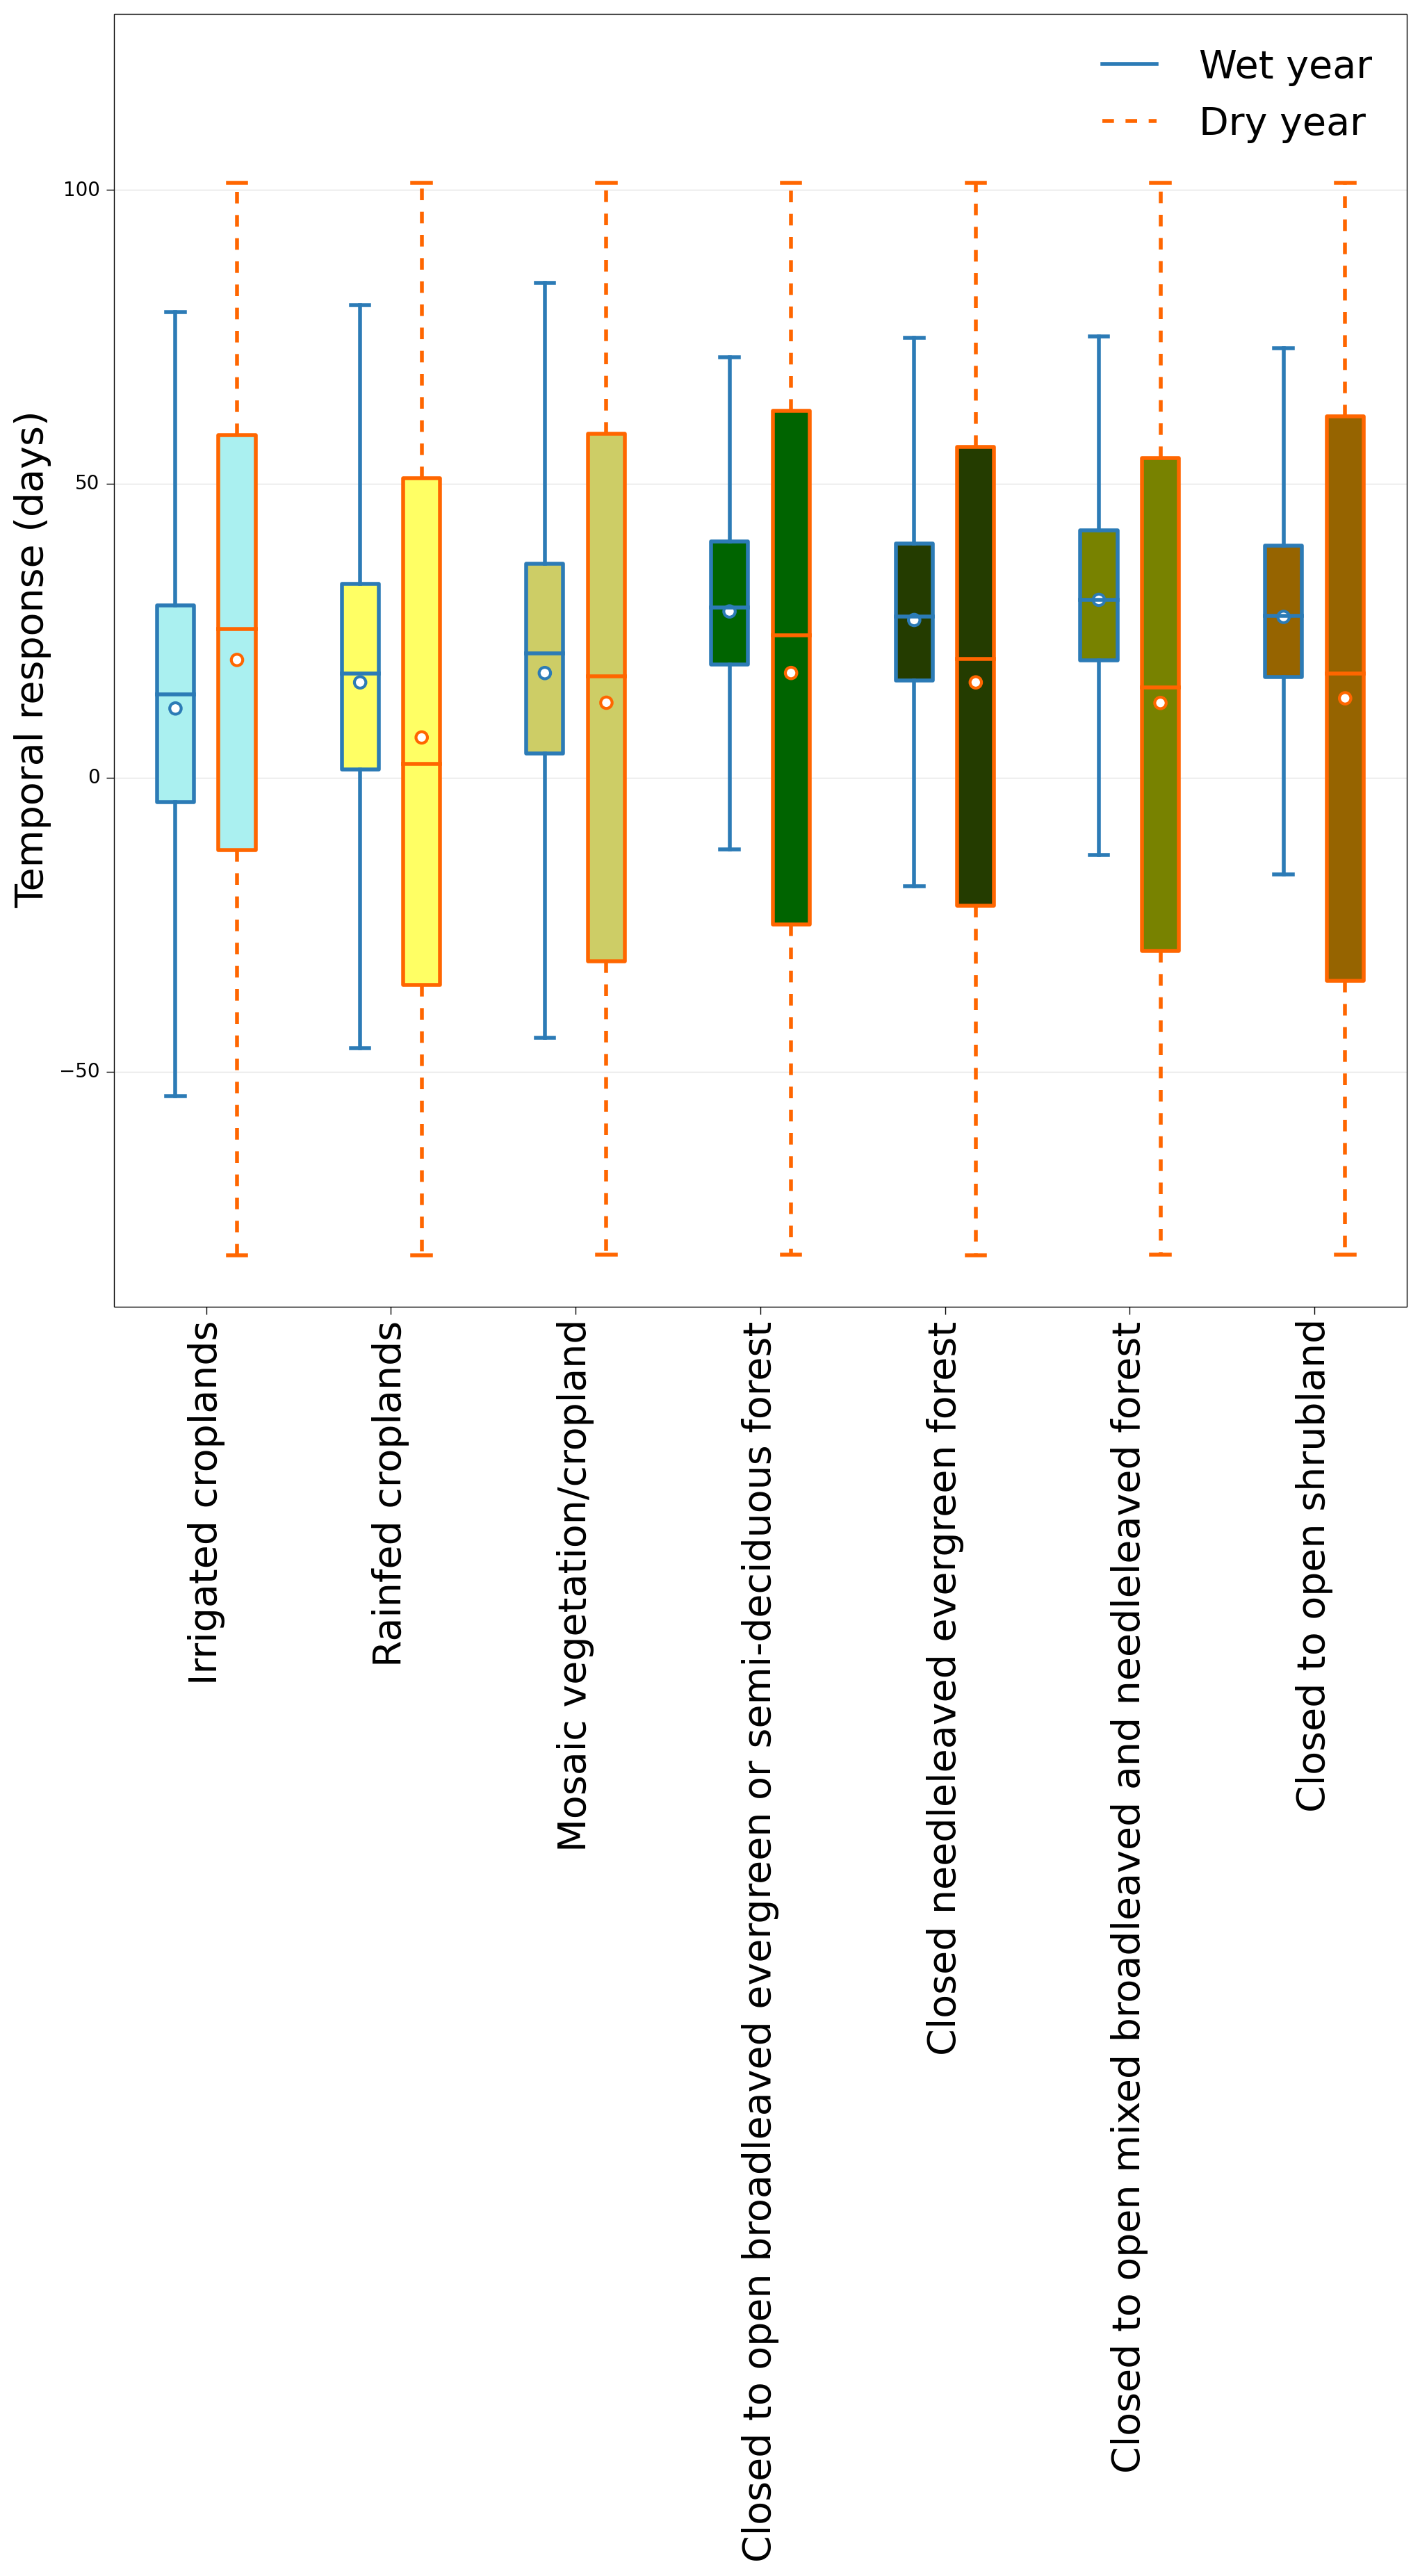

In [30]:
cl14 = [output2008[0],output2009[0]]
cl20 = [output2008[1],output2009[1]]
cl30 = [output2008[2],output2009[2]]
cl90 = [output2008[3],output2009[3]]
cl140 = [output2008[4],output2009[4]]
cl150 = [output2008[5],output2009[5]]
cl200 = [output2008[6],output2009[6]]
#cl210 = [output2008[7],output2009[7]]

mean_bp_wet = np.array((np.nanmean(cl14[0]),np.nanmean(cl20[0]), np.nanmean(cl30[0]), np.nanmean(cl90[0]), np.nanmean(cl140[0]), np.nanmean(cl150[0]), np.nanmean(cl200[0]) ))
mean_bp_dry = np.array((np.nanmean(cl14[1]),np.nanmean(cl20[1]), np.nanmean(cl30[1]), np.nanmean(cl90[1]), np.nanmean(cl140[1]), np.nanmean(cl150[1]), np.nanmean(cl200[1]) ))


from pylab import plot, show, savefig, xlim, figure, \
                hold, ylim, legend, boxplot, setp, axes

# function for setting the colors of the box plots pairs
def setBoxColors(bp):

    setp(bp['boxes'][0], color="#2C7BB6", linewidth=2)
    setp(bp['caps'][0], color="#2C7BB6", linewidth=2)
    setp(bp['caps'][1], color="#2C7BB6", linewidth=2)
    setp(bp['whiskers'][0], color="#2C7BB6", linestyle='-', linewidth=2)
    setp(bp['whiskers'][1], color="#2C7BB6", linestyle='-', linewidth=2)
    setp(bp['fliers'][0], color="#2C7BB6", linewidth=2)
    setp(bp['fliers'][1], color="#2C7BB6", linewidth=2)
    setp(bp['medians'][0], color="#2C7BB6", linewidth=2)

    setp(bp['boxes'][1], color='#FF6600', linewidth=2)
    setp(bp['caps'][2], color='#FF6600', linewidth=2)
    setp(bp['caps'][3], color='#FF6600', linewidth=2)
    setp(bp['whiskers'][2], color='#FF6600', linestyle='--', linewidth=2)
    setp(bp['whiskers'][3], color='#FF6600', linestyle='--', linewidth=2)
    setp(bp['fliers'][2], color='#FF6600', linewidth=2)
    setp(bp['fliers'][3], color='#FF6600', linewidth=2)
    setp(bp['medians'][1], color='#FF6600', linewidth=2)

medians = []
irq_all = []

fig = figure(figsize=(12,12))

ax = axes()
hold(True)
cl_boxes = ['#AAF0F0','#FFFF64', '#CDCD66', '#006400', '#243C00', '#788200', '#966400','#0046C8']
#cl_boxes = ['#ffff64', '#dcf064', '#cdcd66', '#286400', '#ffb432', '#ffebaf', '#fff5d7']

# 1st boxplot pair
bp = boxplot(cl14, positions = [1, 2], widths = 0.6, sym='', patch_artist=True)
setBoxColors(bp)
plt.setp(bp['boxes'],facecolor=cl_boxes[0])

medians.append(bp['medians'][0].get_ydata()[0])
medians.append(bp['medians'][1].get_ydata()[0])
pth = bp['boxes'][0].get_path().get_extents()
irq = [pth.y0,pth.y1]
irq_all.append(irq)
pth = bp['boxes'][1].get_path().get_extents()
irq = [pth.y0,pth.y1]
irq_all.append(irq)

# 2nd boxplot pair
bp = boxplot(cl20, positions = [4, 5], widths = 0.6, sym='', patch_artist=True)
setBoxColors(bp)
plt.setp(bp['boxes'],facecolor=cl_boxes[1])

medians.append(bp['medians'][0].get_ydata()[0])
medians.append(bp['medians'][1].get_ydata()[0])
pth = bp['boxes'][0].get_path().get_extents()
irq = [pth.y0,pth.y1]
irq_all.append(irq)
pth = bp['boxes'][1].get_path().get_extents()
irq = [pth.y0,pth.y1]
irq_all.append(irq)

# 3rd boxplot pair
bp = boxplot(cl30, positions = [7, 8], widths = 0.6, sym='', patch_artist=True)
setBoxColors(bp)
plt.setp(bp['boxes'],facecolor=cl_boxes[2])

medians.append(bp['medians'][0].get_ydata()[0])
medians.append(bp['medians'][1].get_ydata()[0])
pth = bp['boxes'][0].get_path().get_extents()
irq = [pth.y0,pth.y1]
irq_all.append(irq)
pth = bp['boxes'][1].get_path().get_extents()
irq = [pth.y0,pth.y1]
irq_all.append(irq)

# 4th boxplot pair
bp = boxplot(cl90, positions = [10, 11], widths = 0.6, sym='', patch_artist=True)
setBoxColors(bp)
plt.setp(bp['boxes'],facecolor=cl_boxes[3])

medians.append(bp['medians'][0].get_ydata()[0])
medians.append(bp['medians'][1].get_ydata()[0])
pth = bp['boxes'][0].get_path().get_extents()
irq = [pth.y0,pth.y1]
irq_all.append(irq)
pth = bp['boxes'][1].get_path().get_extents()
irq = [pth.y0,pth.y1]
irq_all.append(irq)

# 5th boxplot pair
bp = boxplot(cl140, positions = [13, 14], widths = 0.6, sym='', patch_artist=True)
setBoxColors(bp)
plt.setp(bp['boxes'],facecolor=cl_boxes[4])

medians.append(bp['medians'][0].get_ydata()[0])
medians.append(bp['medians'][1].get_ydata()[0])
pth = bp['boxes'][0].get_path().get_extents()
irq = [pth.y0,pth.y1]
irq_all.append(irq)
pth = bp['boxes'][1].get_path().get_extents()
irq = [pth.y0,pth.y1]
irq_all.append(irq)

# 6th boxplot pair
bp = boxplot(cl150, positions = [16, 17], widths = 0.6, sym='', patch_artist=True)
setBoxColors(bp)
plt.setp(bp['boxes'],facecolor=cl_boxes[5])

medians.append(bp['medians'][0].get_ydata()[0])
medians.append(bp['medians'][1].get_ydata()[0])
pth = bp['boxes'][0].get_path().get_extents()
irq = [pth.y0,pth.y1]
irq_all.append(irq)
pth = bp['boxes'][1].get_path().get_extents()
irq = [pth.y0,pth.y1]
irq_all.append(irq)

# 7th boxplot pair
bp = boxplot(cl200, positions = [19, 20], widths = 0.6, sym='', patch_artist=True)
setBoxColors(bp)
plt.setp(bp['boxes'],facecolor=cl_boxes[6])

medians.append(bp['medians'][0].get_ydata()[0])
medians.append(bp['medians'][1].get_ydata()[0])
pth = bp['boxes'][0].get_path().get_extents()
irq = [pth.y0,pth.y1]
irq_all.append(irq)
pth = bp['boxes'][1].get_path().get_extents()
irq = [pth.y0,pth.y1]
irq_all.append(irq)

## ADD MEAN values
scatter([1,4,7,10,13,16,19], mean_bp_wet, c='w', edgecolor="#2C7BB6", marker='o', s=35, linewidths=1.5, zorder=2)
scatter([2,5,8,11,14,17,20], mean_bp_dry, c='w', edgecolor='#FF6600', marker='o', s=35, linewidths=1.5, zorder=2)

# set axes limits and labels
xlim(0,21)
ylim(-90,130)
ylabel('Temporal response (days)', fontsize=20)
ax.set_xticklabels(['Irrigated croplands','Rainfed croplands', 'Mosaic vegetation/cropland', 'Closed to open broadleaved evergreen or semi-deciduous forest',
         'Closed needleleaved evergreen forest', 'Closed to open mixed broadleaved and needleleaved forest', 
         'Closed to open shrubland'], rotation='vertical', fontsize=20)

#ax.set_xticklabels(['Rainfed croplands', 'Mosaic Croplands/Vegetation', 'Mosaic Vegetation/Croplands',
#         'Open needleleaved deciduous', 'Closed to open grassland', 
#         'Sparse vegetation', 'Bare areas'], rotation='vertical', fontsize=20)
ax.set_xticks([1.5, 4.5, 7.5, 10.5, 13.5, 16.5, 19.5])


# draw temporary red and blue lines and use them to create a legend
hB, = plot([1,1], color="#2C7BB6", linestyle='-', linewidth=2)
hR, = plot([1,1],color='#FF6600', linestyle='--', linewidth=2)
legend((hB, hR),('Wet year', 'Dry year'), fontsize=20, frameon=False)
hB.set_visible(False)
hR.set_visible(False)

#savefig('boxcompare.png')
#fig.tight_layout()
#plt.title('MERIS stratification for AWC class 8.7 - 10.9 %', fontsize=20)
plt.grid(axis='y')
plt.tick_params(\
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    right ='off',
    labelbottom='on') # labels along the bottom edge are off
show()

path2print = r'D:\Data\0_DAILY_INTERVAL_NDVI_TRMM\Jiujang//2_meris_stratification_for_awc_2010_noHANTSforTRMM_2007.png'
fig.savefig(path2print, dpi=400)

Stratification of PHASE and AWC

In [20]:
path = r'D:\Data\0_DAILY_INTERVAL_NDVI_TRMM\Jiujang\SoilRetention\sm_awc//sm_awc_49_3.tif'
ds = gdal.Open(path)
bd = ds.GetRasterBand(1)
ar = bd.ReadAsArray()
awc_msk = np.flipud(ar)
awc_msk = np.ma.masked_array(awc_msk, array08.mask)

#path = r'J:\New folder\AWC_CLASS2\meris//meris_cn.tif'
#ds = gdal.Open(path)
#bd = ds.GetRasterBand(1)
#ar = bd.ReadAsArray()
#meris_msk = np.flipud(ar)
#meris_msk = np.ma.masked_array(meris_msk, array08.mask)

## AWC CLASSIFICATION, CLASSES OF INTEREST
awc_class = np.array([0.099,0.123,0.131,0.136,0.142,0.171])
#meris_class = np.array([14,20,30,90,140,150,200])
awc_names = ['9.9-12.3', '12.3-13.1', '13.1-13.6', '13.6-14.2', '14.2-17.1']  

# ## SETTING UP OF PANDAS DATAFRAME         ]
# clmn = ['0','5', '10', '15', '20', '25', '30', '35', '40']
# clmn2 = ['mean','std']
# iterables = [['Y2008','Y2009'], ['8.7-10.9', '10.9-12.3', '12.3-13.7', '13.7-15.4', '15.4-18.9']]
# idx = pd.MultiIndex.from_product(iterables, names=['YEAR', 'LANDCLASS'])

# df_org = pd.DataFrame(np.random.randn(10, 9), index=idx, columns=clmn)
# df = pd.DataFrame(np.random.randn(10, 9), index=idx, columns=clmn)
# df2 = pd.DataFrame(np.random.randn(10,2), index=idx, columns=clmn2)
output2008 = []
output2009 = []
    
for i in range(5):
    ## PHAE RASTER 2008/2009
    print(awc_class[i],awc_class[i+1])
    ph_awc_09 = np.ma.masked_where((awc_msk < awc_class[i])|(awc_msk > awc_class[i+1]), array09) # cross spectrum # amp09 # amplitude ratio
    ph_awc_08 = np.ma.masked_where((awc_msk < awc_class[i])|(awc_msk > awc_class[i+1]), array08) # cross spectrum # amp08 # """"
    
    #ph_r_09 = np.ma.masked_where(meris_msk <> meris_class[i], array09)
    #ph_r_08 = np.ma.masked_where(meris_msk <> meris_class[i], array08)

#     ## HISTOGRAM
#     r08, bin08 = np.histogram(ph_awc_08.compressed(), bins=9, range=[-5,40])
#     r09, bin09 = np.histogram(ph_awc_09.compressed(), bins=9, range=[-5,40])
    
#     # compute mean ans standard deviation for both ph_awc_mer_08 and xx_09
#     mean_std_08 = np.array([ph_awc_08.compressed().mean(), ph_awc_08.compressed().std()])
#     mean_std_09 = np.array([ph_awc_09.compressed().mean(), ph_awc_09.compressed().std()]) 
    
    output2008.append(ph_awc_08.compressed())
    output2009.append(ph_awc_09.compressed())
    
#     print r08, r09
#     df.loc[(iterables[0][1],iterables[1][i])] = r09.astype(float)/sum(r09)*100 #('Y2009'
#     df.loc[(iterables[0][0],iterables[1][i])] = r08.astype(float)/sum(r08)*100 #('Y2008'
#     df_org.loc[(iterables[0][1],iterables[1][i])] = r09.astype(float)#/sum(r09)*100 #('Y2009'
#     df_org.loc[(iterables[0][0],iterables[1][i])] = r08.astype(float)#/sum(r08)*100 #('Y2008'    
#     df2.loc[(iterables[0][0],iterables[1][i])] = mean_std_08 #Y2008
#     df2.loc[(iterables[0][1],iterables[1][i])] = mean_std_09 #Y2009    
    
#     fig, ax = plt.subplots(figsize=[7,6])
#     width = 2
#     rects1 = ax.bar(bin08[1::], r08.astype(float)/sum(r08)*100, width, color="#2C7BB6")#BLUE)
#     rects2 = ax.bar(bin08[1::]-width, r09.astype(float)/sum(r09)*100, width, color="#FF6600")#ORANGE)
#     plt.grid(True, axis='y')
#     plt.legend(['2008 Wet Year','2009 Dry Year'], )#fontsize=6)
#     plt.xlim(xmin=-2.5, xmax=42.5)
#     plt.xticks([0,5,10,15,20,25,30,35,40],)# size=7)
#     plt.ylabel('Percentage(%)', )#size=7)
#     #plt.yticks(size=7)
#     plt.xlabel('Phase Delay(days)',)# size=7)
#     plt.title(names[i])#, size=7)
#     plt.show()  
#     plt.savefig(outPath, dpi=400)
#     print outPath

(0.099000000000000005, 0.123)
(0.123, 0.13100000000000001)
(0.13100000000000001, 0.13600000000000001)
(0.13600000000000001, 0.14199999999999999)
(0.14199999999999999, 0.17100000000000001)


In [21]:
output2008[0].mean()

nan

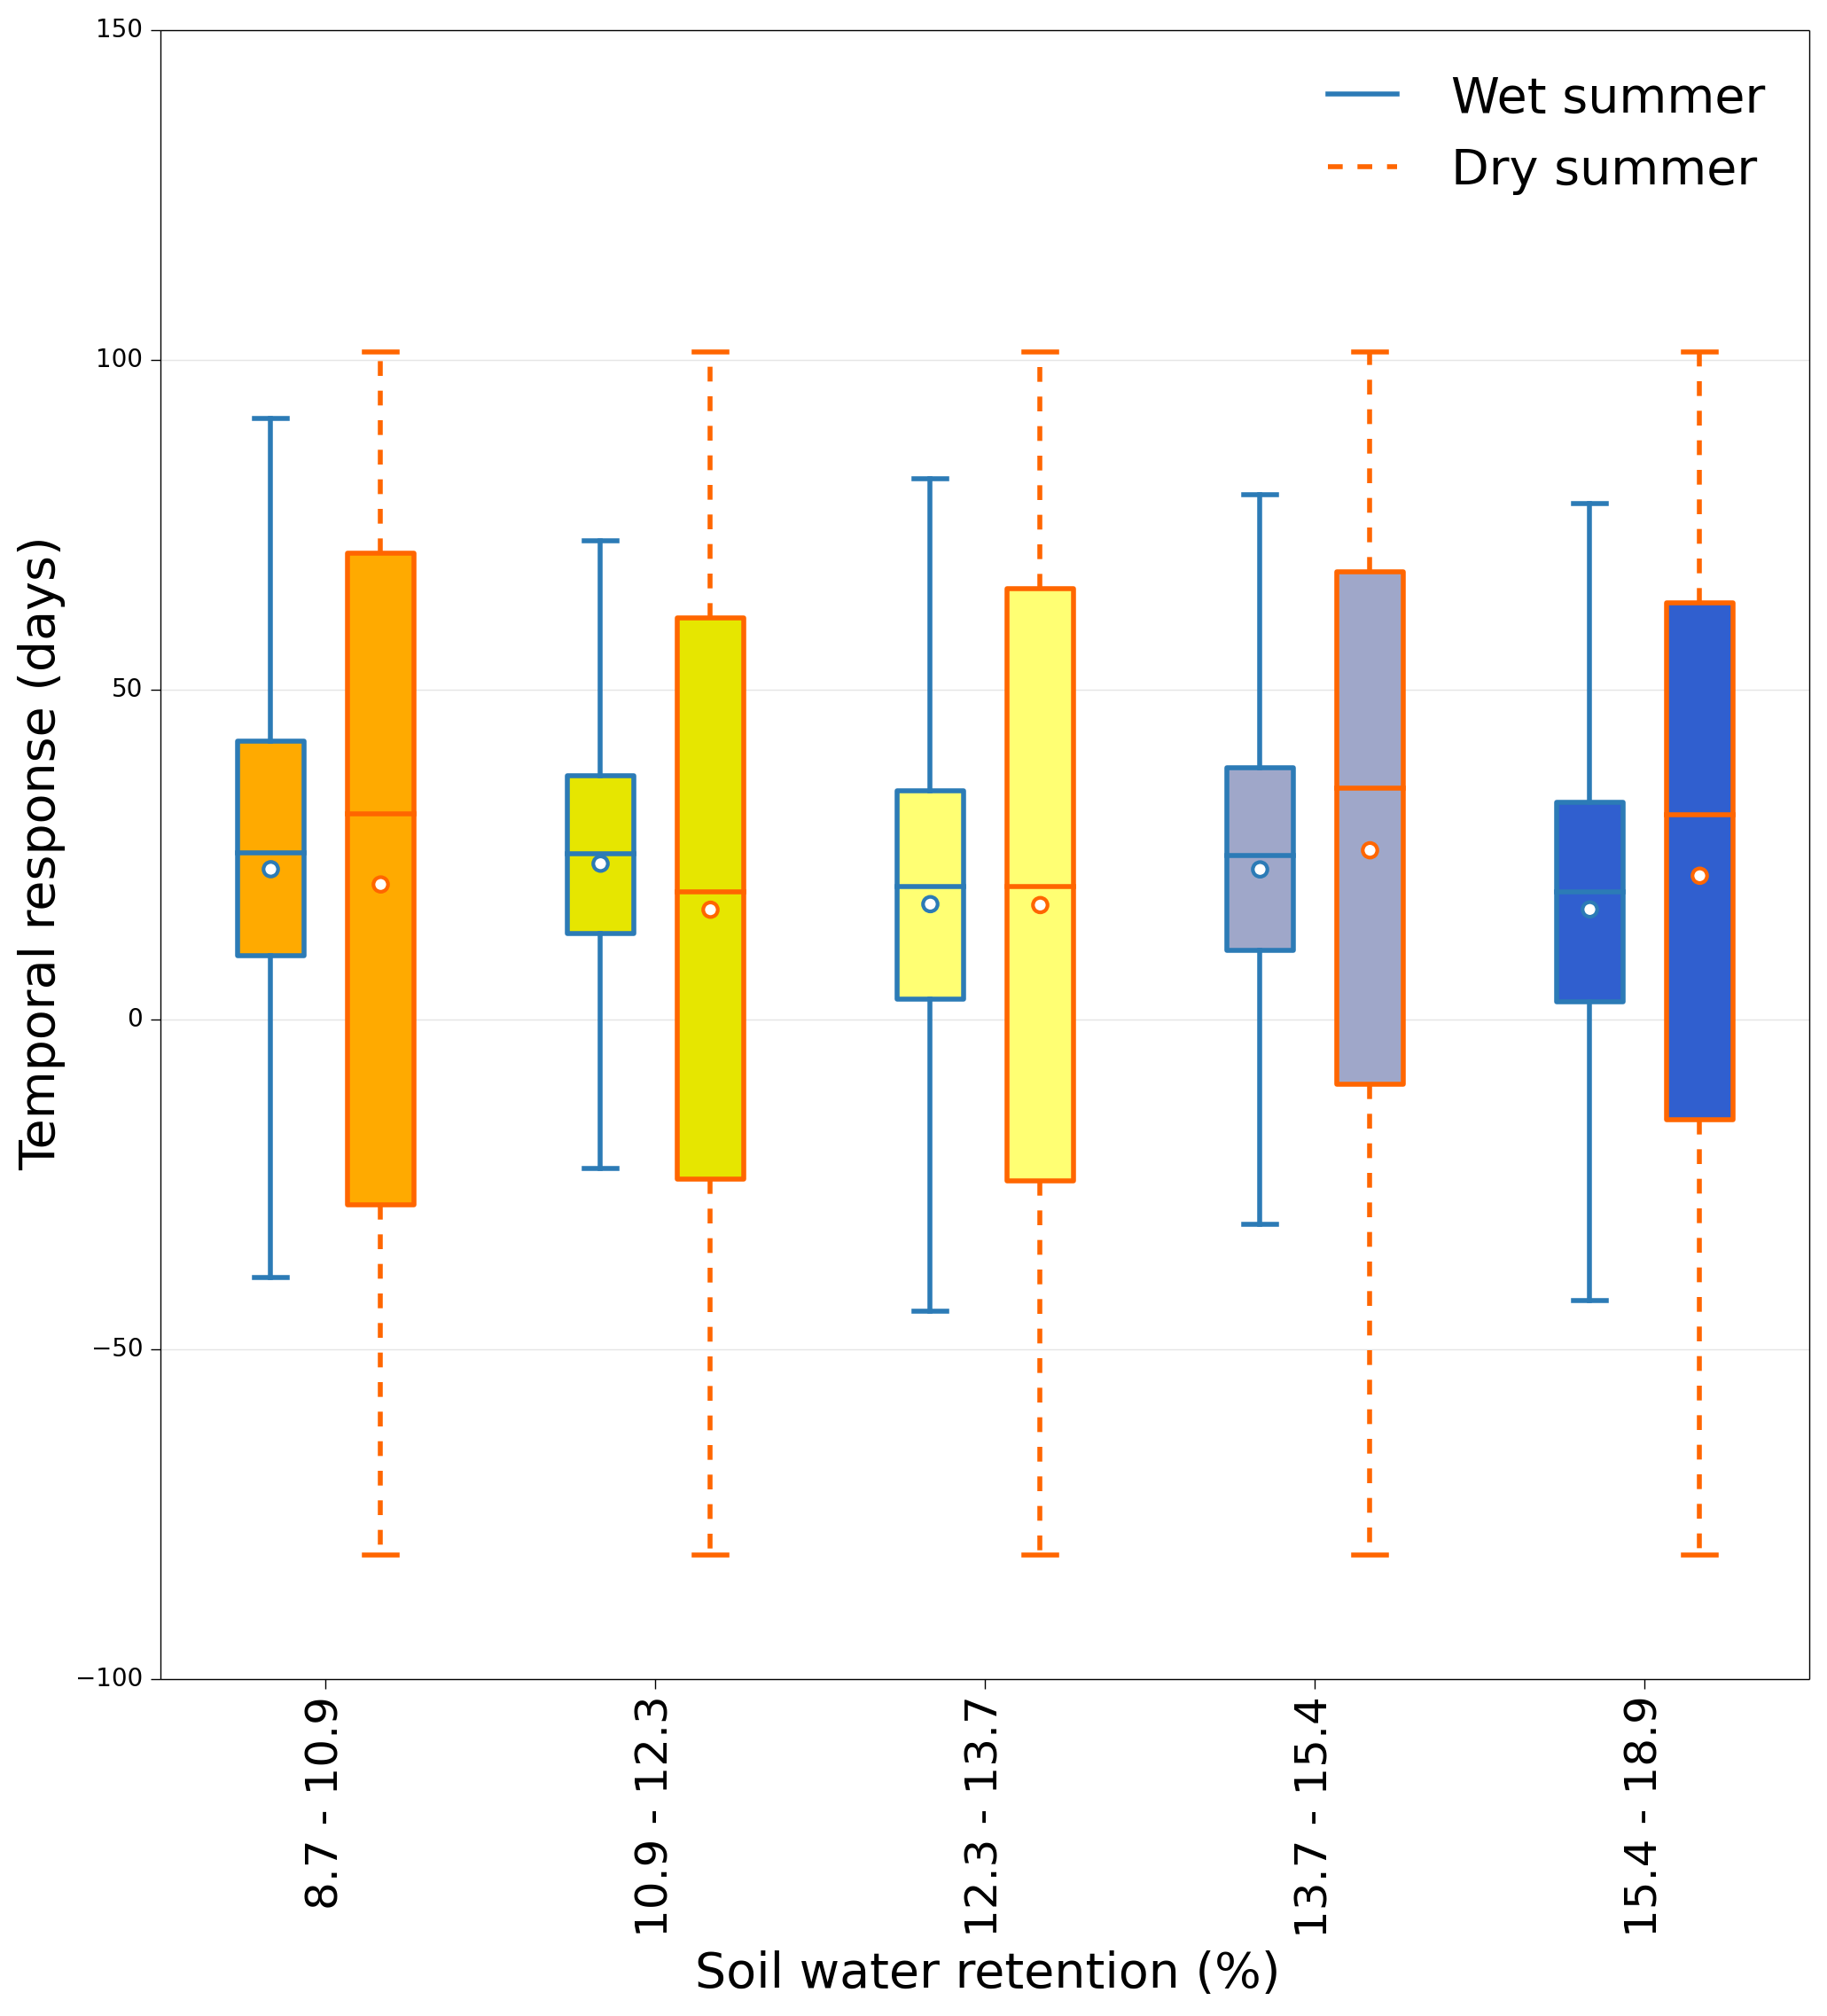

In [22]:
cl14 = [output2008[0],output2009[0]]
cl20 = [output2008[1],output2009[1]]
cl30 = [output2008[2],output2009[2]]
cl90 = [output2008[3],output2009[3]]
cl140 = [output2008[4],output2009[4]]
#cl150 = [output2008[5],output2009[5]]
#cl200 = [output2008[6],output2009[6]]
mean_bp_wet = np.array((np.nanmean(cl14[0]),np.nanmean(cl20[0]), np.nanmean(cl30[0]), np.nanmean(cl90[0]), np.nanmean(cl140[0]) ))
mean_bp_dry = np.array((np.nanmean(cl14[1]),np.nanmean(cl20[1]), np.nanmean(cl30[1]), np.nanmean(cl90[1]), np.nanmean(cl140[1]) ))

from pylab import plot, show, savefig, xlim, figure, \
                hold, ylim, legend, boxplot, scatter, setp, getp, axes

# function for setting the colors of the box plots pairs
def setBoxColors(bp):

    setp(bp['boxes'][0], color="#2C7BB6", linewidth=2)
    setp(bp['caps'][0], color="#2C7BB6", linewidth=2)
    setp(bp['caps'][1], color="#2C7BB6", linewidth=2)
    setp(bp['whiskers'][0], color="#2C7BB6", linestyle='-', linewidth=2)
    setp(bp['whiskers'][1], color="#2C7BB6", linestyle='-', linewidth=2)
    setp(bp['fliers'][0], color="#2C7BB6", linewidth=2)
    setp(bp['fliers'][1], color="#2C7BB6", linewidth=2)
    setp(bp['medians'][0], color="#2C7BB6", linewidth=2)

    setp(bp['boxes'][1], color='#FF6600', linewidth=2)
    setp(bp['caps'][2], color='#FF6600', linewidth=2)
    setp(bp['caps'][3], color='#FF6600', linewidth=2)
    setp(bp['whiskers'][2], color='#FF6600', linestyle='--', linewidth=2)
    setp(bp['whiskers'][3], color='#FF6600', linestyle='--', linewidth=2)
    setp(bp['fliers'][2], color='#FF6600', linewidth=2)
    setp(bp['fliers'][3], color='#FF6600', linewidth=2)
    setp(bp['medians'][1], color='#FF6600', linewidth=2)

medians = []
irq_all = []
fig = figure(figsize=(12,12))

ax = axes()
hold(True)
cl_boxes = ['#ffaa00', '#e6e600', '#ffff73', '#9fa7c9', '#305fcf']

# 1st boxplot pair
bp = boxplot(cl14, positions = [1, 2], widths = 0.6, sym='', patch_artist=True)
setBoxColors(bp)
plt.setp(bp['boxes'],facecolor=cl_boxes[0])
medians.append(bp['medians'][0].get_ydata()[0])
medians.append(bp['medians'][1].get_ydata()[0])
pth = bp['boxes'][0].get_path().get_extents()
irq = [pth.y0,pth.y1]
irq_all.append(irq)
pth = bp['boxes'][1].get_path().get_extents()
irq = [pth.y0,pth.y1]
irq_all.append(irq)

# 2nd boxplot pair
bp = boxplot(cl20, positions = [4, 5], widths = 0.6, sym='', patch_artist=True)
setBoxColors(bp)
plt.setp(bp['boxes'],facecolor=cl_boxes[1])
medians.append(bp['medians'][0].get_ydata()[0])
medians.append(bp['medians'][1].get_ydata()[0])
pth = bp['boxes'][0].get_path().get_extents()
irq = [pth.y0,pth.y1]
irq_all.append(irq)
pth = bp['boxes'][1].get_path().get_extents()
irq = [pth.y0,pth.y1]
irq_all.append(irq)

# 3rd boxplot pair
bp = boxplot(cl30, positions = [7, 8], widths = 0.6, sym='', patch_artist=True)
setBoxColors(bp)
plt.setp(bp['boxes'],facecolor=cl_boxes[2])
medians.append(bp['medians'][0].get_ydata()[0])
medians.append(bp['medians'][1].get_ydata()[0])
pth = bp['boxes'][0].get_path().get_extents()
irq = [pth.y0,pth.y1]
irq_all.append(irq)
pth = bp['boxes'][1].get_path().get_extents()
irq = [pth.y0,pth.y1]
irq_all.append(irq)

# 4th boxplot pair
bp = boxplot(cl90, positions = [10, 11], widths = 0.6, sym='', patch_artist=True)
setBoxColors(bp)
plt.setp(bp['boxes'],facecolor=cl_boxes[3])
medians.append(bp['medians'][0].get_ydata()[0])
medians.append(bp['medians'][1].get_ydata()[0])
pth = bp['boxes'][0].get_path().get_extents()
irq = [pth.y0,pth.y1]
irq_all.append(irq)
pth = bp['boxes'][1].get_path().get_extents()
irq = [pth.y0,pth.y1]
irq_all.append(irq)

# 5th boxplot pair
bp = boxplot(cl140, positions = [13, 14], widths = 0.6, sym='', patch_artist=True)
setBoxColors(bp)
plt.setp(bp['boxes'],facecolor=cl_boxes[4])
medians.append(bp['medians'][0].get_ydata()[0])
medians.append(bp['medians'][1].get_ydata()[0])
pth = bp['boxes'][0].get_path().get_extents()
irq = [pth.y0,pth.y1]
irq_all.append(irq)
pth = bp['boxes'][1].get_path().get_extents()
irq = [pth.y0,pth.y1]
irq_all.append(irq)

# # 6th boxplot pair
# bp = boxplot(cl150, positions = [16, 17], widths = 0.6, sym='', patch_artist=True)
# setBoxColors(bp)
# plt.setp(bp['boxes'],facecolor=cl_boxes[5])

# # 7th boxplot pair
# bp = boxplot(cl200, positions = [19, 20], widths = 0.6, sym='', patch_artist=True)
# setBoxColors(bp)
# plt.setp(bp['boxes'],facecolor=cl_boxes[6])

scatter([1,4,7,10,13], mean_bp_wet, c='w', edgecolor="#2C7BB6", marker='o', s=35, linewidths=1.5, zorder=2)
scatter([2,5,8,11,14], mean_bp_dry, c='w', edgecolor='#FF6600', marker='o', s=35, linewidths=1.5, zorder=2)
# set axes limits and labels
xlim(0,15)
#ylim(130,270)
#ax.hlines(1, 0, 21, linewidth=2, zorder=0)
ylabel('Temporal response (days)', fontsize=20)
xlabel('Soil water retention (%)', fontsize=20)
ax.set_xticklabels(['8.7 - 10.9', '10.9 - 12.3', '12.3 - 13.7', '13.7 - 15.4', '15.4 - 18.9'], rotation='vertical', fontsize=18)
ax.set_xticks([1.5, 4.5, 7.5, 10.5, 13.5])


# draw temporary red and blue lines and use them to create a legend
hB, = plot([1,1], color="#2C7BB6", linestyle='-', linewidth=2)
hR, = plot([1,1],color='#FF6600', linestyle='--', linewidth=2)
legend((hB, hR),('Wet summer', 'Dry summer'), fontsize=20, frameon=False)
hB.set_visible(False)
hR.set_visible(False)

#savefig('boxcompare.png')
#fig.tight_layout()
plt.grid(axis='y')
plt.tick_params(\
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    right ='off',
    labelbottom='on') # labels along the bottom edge are off
show()

path2print = r'D:\Data\0_DAILY_INTERVAL_NDVI_TRMM\Jiujang//phase_stratification_for_awc_2006_noHANTSforTRMM_2007.png'
fig.savefig(path2print, dpi=400)

In [35]:
variable_out = 2
if variable_out == 1:
    outliers = "Hi"    
elif variable_out == 2:
    outliers = "Lo"
else:
    outliers = "None"

Lo


PHASE stratfication based on MERIS and AWC

In [99]:
#clmn = ['days 0','days 5', 'days 10', 'days 15', 'days 20', 'days 25', 'days 30', 'days 35', 'days 40']
#clmn = ['0','5', '10', '15', '20', '25', '30', '35', '40']
#clmn2 = ['mean','std']
#iterables = [['Y2008','Y2009'], ['AWC0877-1087', 'AWC1087-1230', 'AWC1230-1369', 'AWC1369-1539', 'AWC1539-1885'], 
#             ['14 - Rainfed croplands', '20 - Mosaic Croplands/Vegetation', '30 - Mosaic Vegetation/Croplands',
#             '90 - Open needleleaved deciduous or evergreen forest', '140 - Closed to open grassland', 
#             '150 - Sparse vegetation', '200 - Bare areas' 
#             ]]
#idx = pd.MultiIndex.from_product(iterables, names=['YEAR','SWHC', 'LANDCLASS'])

#df_org = pd.DataFrame(np.random.randn(70, 9), index=idx, columns=clmn)
#df = pd.DataFrame(np.random.randn(70, 9), index=idx, columns=clmn)
#df2 = pd.DataFrame(np.random.randn(70,2), index=idx, columns=clmn2)

## AWC CLASSIFICATION, CLASSES OF INTEREST
awc_class = np.array([0.099,0.123,0.131,0.136,0.142,0.171])
#meris_class = np.array([14,20,30,90,140,150,200])
awc_names = ['9.9-12.3', '12.3-13.1', '13.1-13.6', '13.6-14.2', '14.2-17.1'] 

#awc_class = np.array([0.0001,0.1087,0.1230,0.1369,0.1539,0.1889])
## MERIS CLASSIFICATION, CLASSES OF INTEREST
meris_class = np.array([11,14,30,40,70,100,130,210])
meris_names = ['11 - Irrigated croplands','14 - Rainfed croplands','30 - Mosaic vegetation/croplands',
'40 - Closed to open broadleaved evergreen or semi-deciduous forest', '70 - Closed needleleaved evergreen forest', 
'100 - Closed to open mixed broadleaved and needleleaved forest','130 - Closed to open shrubland', '210 - Water bodies'] 

output2008 = []
output2009 = []

for i in range(5):
    # mask where available water class is in between two classes for dry year (ph_awc_09) and wet year (ph_awc_08), 
    # mask is applied on array09 and array08 both valid
    print('Soil water retention: ',awc_class[i], awc_class[i+1])    
    ph_awc_msk = np.ma.masked_where((awc_msk < awc_class[i])|(awc_msk > awc_class[i+1]),awc_msk)
    
    for j in range(8):
        print('MERIS classification: ', meris_class[j], meris_names[j])
        # mask where meris landclass is specific landclass                
        ph_mer_msk = np.ma.masked_where(meris_msk <> meris_class[j], meris_msk)
        
        ph_awc_mer_msk_08 = ph_awc_msk.mask + ph_mer_msk.mask + array08.mask
        ph_awc_mer_msk_09 = ph_awc_msk.mask + ph_mer_msk.mask + array09.mask
        
        ph_awc_mer_08 = np.ma.masked_array(array08.data, ph_awc_mer_msk_08)
        ph_awc_mer_09 = np.ma.masked_array(array09.data, ph_awc_mer_msk_09)        
        
        # apply histograms on the classification in range -5,40 with stepsize 5.
        r08, bin08 = np.histogram(ph_awc_mer_08.compressed(), bins=9, range=[-5,40])
        r09, bin09 = np.histogram(ph_awc_mer_09.compressed(), bins=9, range=[-5,40])
        
        # compute mean ans standard deviation for both ph_awc_mer_08 and xx_09
        mean_std_08 = np.array([np.nanmean(ph_awc_mer_08.compressed()), np.nanstd(ph_awc_mer_08.compressed())])
        mean_std_09 = np.array([np.nanmean(ph_awc_mer_09.compressed()), np.nanstd(ph_awc_mer_09.compressed())])

        output2008.append(ph_awc_mer_08.compressed())
        output2009.append(ph_awc_mer_09.compressed())        

#        df.loc[(iterables[0][1],iterables[1][i],iterables[2][j])] = r09.astype(float)/sum(r09)*100 #('Y2009'
#        df.loc[(iterables[0][0],iterables[1][i],iterables[2][j])] = r08.astype(float)/sum(r08)*100 #('Y2008'
#        df_org.loc[(iterables[0][1],iterables[1][i],iterables[2][j])] = r09.astype(float)#/sum(r09)*100 #('Y2009'
#        df_org.loc[(iterables[0][0],iterables[1][i],iterables[2][j])] = r08.astype(float)#/sum(r08)*100 #('Y2008'    
#        df2.loc[(iterables[0][0],iterables[1][i], iterables[2][j])] = mean_std_08 #Y2008
#        df2.loc[(iterables[0][1],iterables[1][i], iterables[2][j])] = mean_std_09 #Y2009

('Soil water retention: ', 0.099000000000000005, 0.123)
('MERIS classification: ', 11, '11 - Irrigated croplands')
('MERIS classification: ', 14, '14 - Rainfed croplands')
('MERIS classification: ', 30, '30 - Mosaic vegetation/croplands')
('MERIS classification: ', 40, '40 - Closed to open broadleaved evergreen or semi-deciduous forest')
('MERIS classification: ', 70, '70 - Closed needleleaved evergreen forest')
('MERIS classification: ', 100, '100 - Closed to open mixed broadleaved and needleleaved forest')
('MERIS classification: ', 130, '130 - Closed to open shrubland')
('MERIS classification: ', 210, '210 - Water bodies')
('Soil water retention: ', 0.123, 0.13100000000000001)
('MERIS classification: ', 11, '11 - Irrigated croplands')
('MERIS classification: ', 14, '14 - Rainfed croplands')
('MERIS classification: ', 30, '30 - Mosaic vegetation/croplands')
('MERIS classification: ', 40, '40 - Closed to open broadleaved evergreen or semi-deciduous forest')
('MERIS classification: ', 

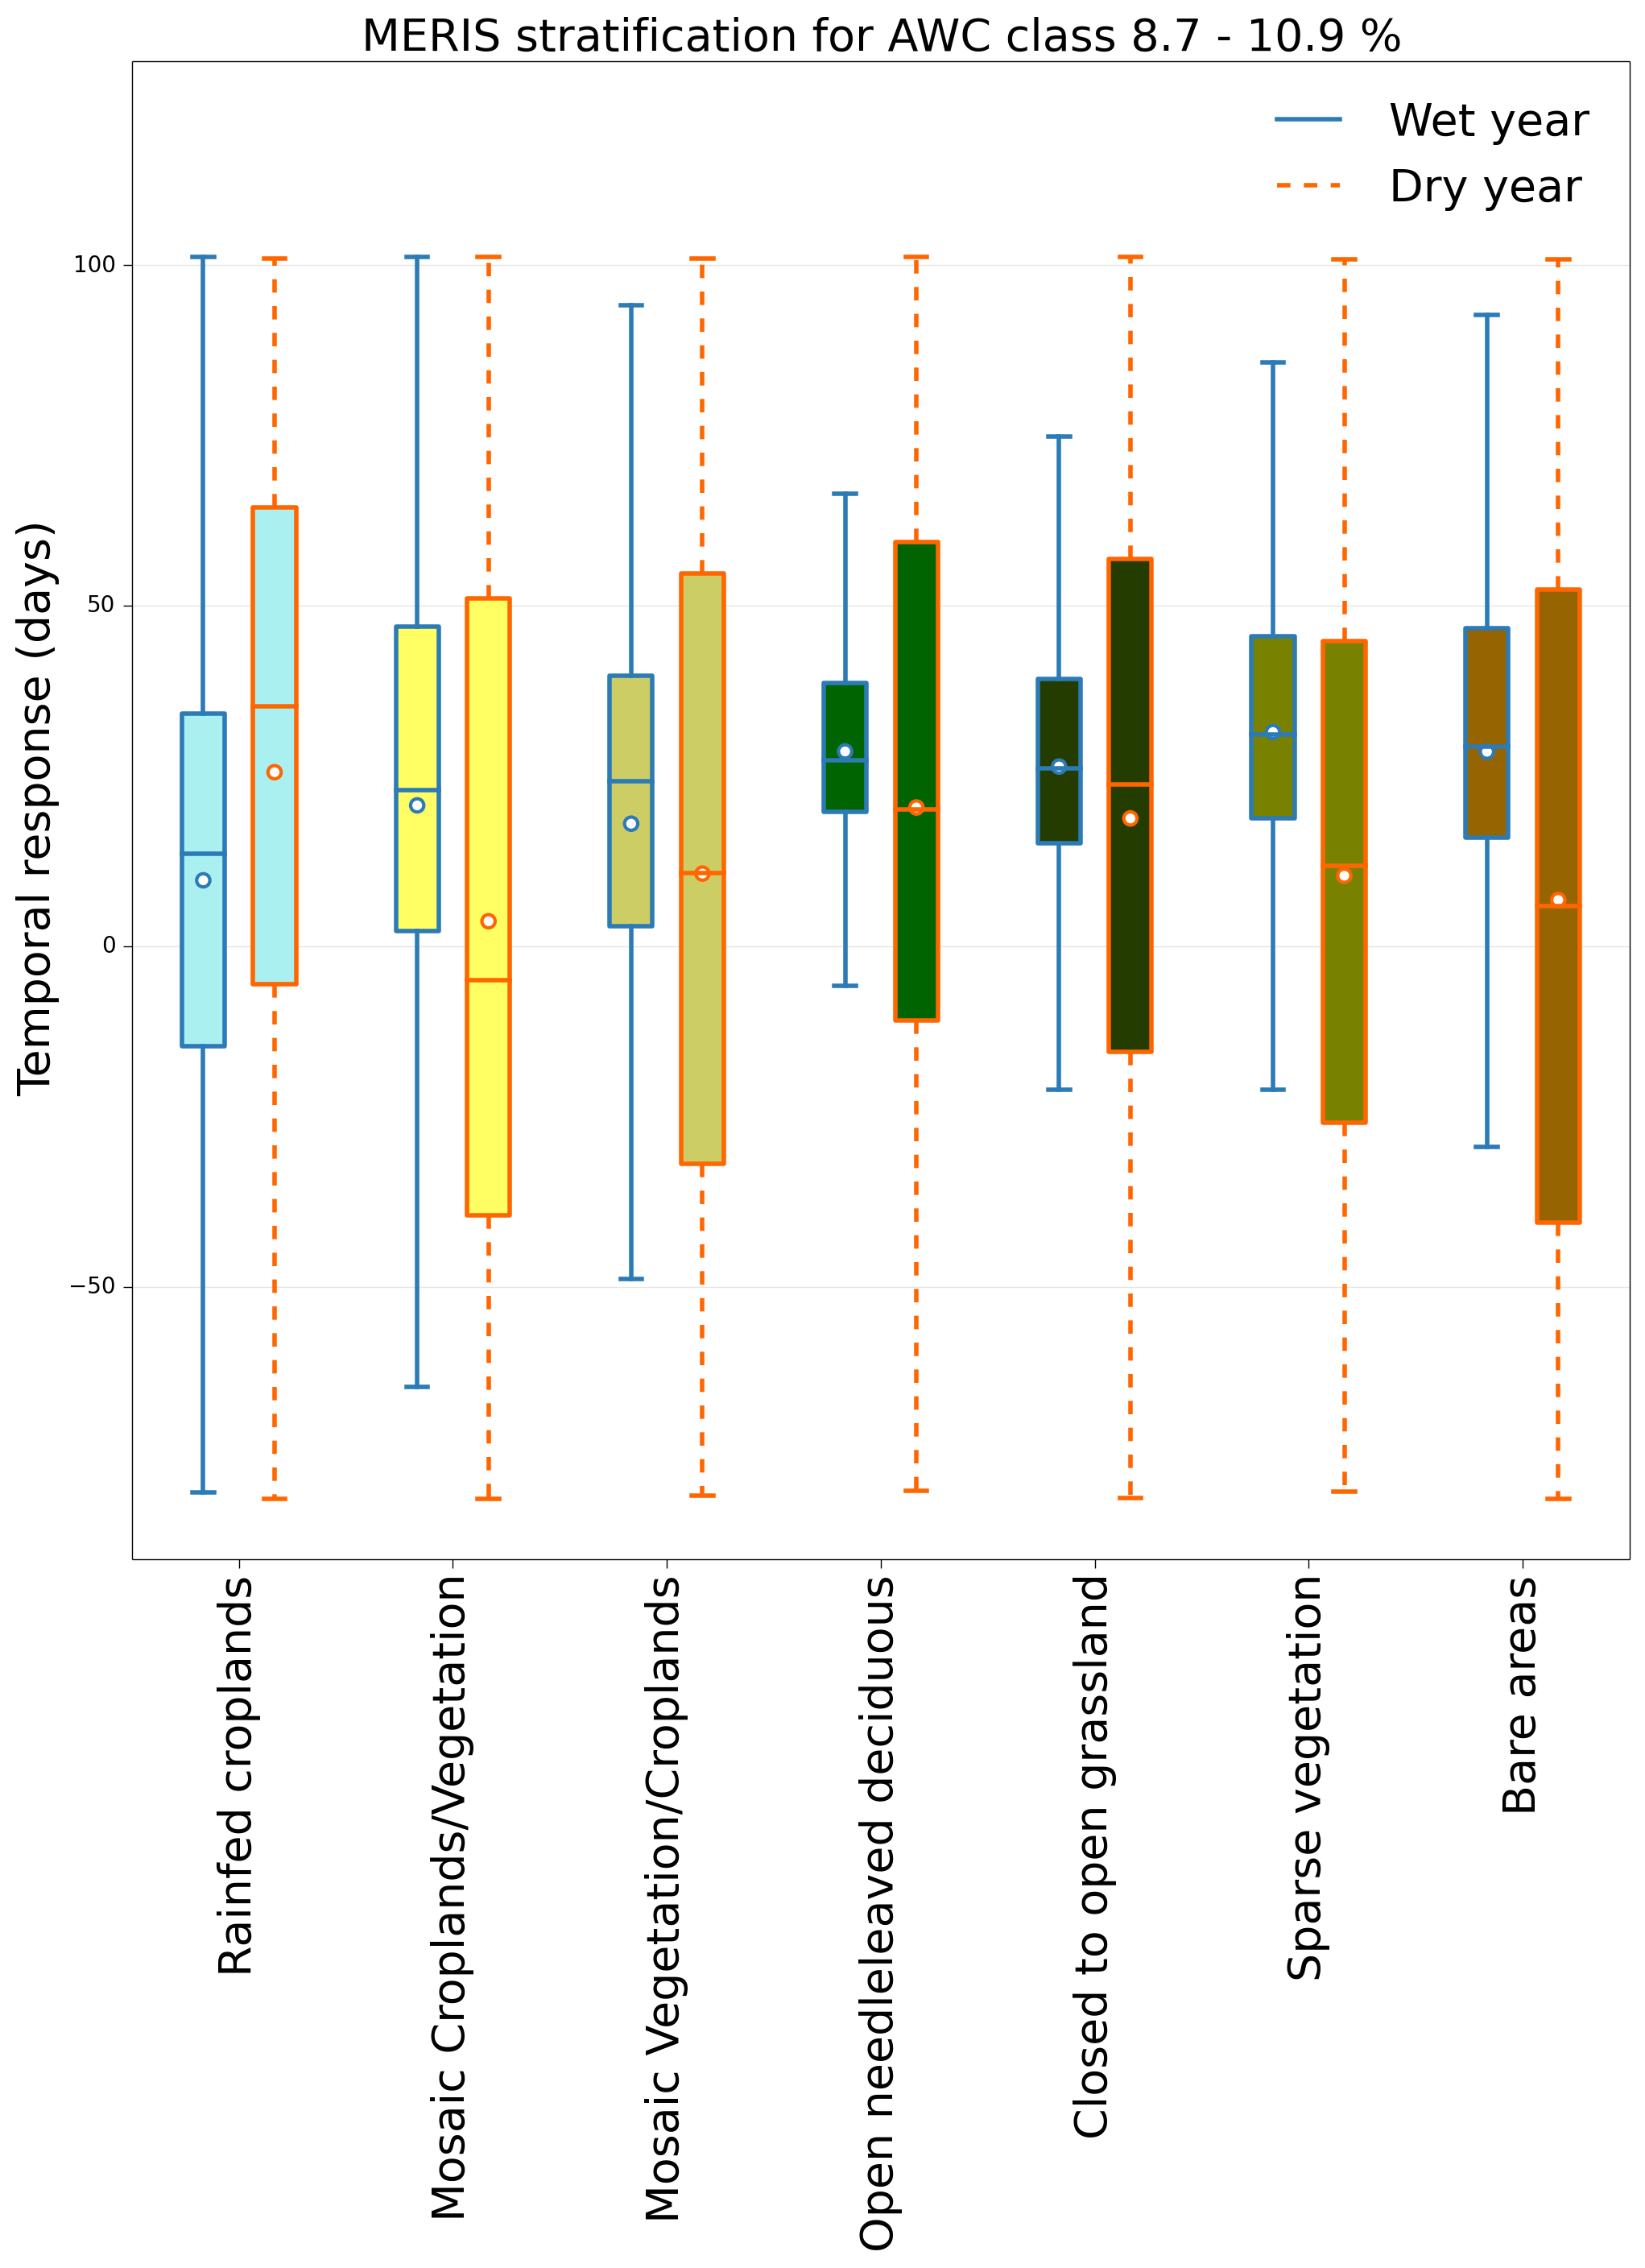

In [100]:
cl14 = [output2008[0],output2009[0]]
cl20 = [output2008[1],output2009[1]]
cl30 = [output2008[2],output2009[2]]
cl90 = [output2008[3],output2009[3]]
cl140 = [output2008[4],output2009[4]]
cl150 = [output2008[5],output2009[5]]
cl200 = [output2008[6],output2009[6]]
#cl210 = [output2008[7],output2009[7]]

mean_bp_wet = np.array((np.nanmean(cl14[0]),np.nanmean(cl20[0]), np.nanmean(cl30[0]), np.nanmean(cl90[0]), np.nanmean(cl140[0]), np.nanmean(cl150[0]), np.nanmean(cl200[0]) ))
mean_bp_dry = np.array((np.nanmean(cl14[1]),np.nanmean(cl20[1]), np.nanmean(cl30[1]), np.nanmean(cl90[1]), np.nanmean(cl140[1]), np.nanmean(cl150[1]), np.nanmean(cl200[1]) ))


from pylab import plot, show, savefig, xlim, figure, \
                hold, ylim, legend, boxplot, setp, axes

# function for setting the colors of the box plots pairs
def setBoxColors(bp):

    setp(bp['boxes'][0], color="#2C7BB6", linewidth=2)
    setp(bp['caps'][0], color="#2C7BB6", linewidth=2)
    setp(bp['caps'][1], color="#2C7BB6", linewidth=2)
    setp(bp['whiskers'][0], color="#2C7BB6", linestyle='-', linewidth=2)
    setp(bp['whiskers'][1], color="#2C7BB6", linestyle='-', linewidth=2)
    setp(bp['fliers'][0], color="#2C7BB6", linewidth=2)
    setp(bp['fliers'][1], color="#2C7BB6", linewidth=2)
    setp(bp['medians'][0], color="#2C7BB6", linewidth=2)

    setp(bp['boxes'][1], color='#FF6600', linewidth=2)
    setp(bp['caps'][2], color='#FF6600', linewidth=2)
    setp(bp['caps'][3], color='#FF6600', linewidth=2)
    setp(bp['whiskers'][2], color='#FF6600', linestyle='--', linewidth=2)
    setp(bp['whiskers'][3], color='#FF6600', linestyle='--', linewidth=2)
    setp(bp['fliers'][2], color='#FF6600', linewidth=2)
    setp(bp['fliers'][3], color='#FF6600', linewidth=2)
    setp(bp['medians'][1], color='#FF6600', linewidth=2)

medians = []
irq_all = []

fig = figure(figsize=(12,12))

ax = axes()
hold(True)
cl_boxes = ['#AAF0F0','#FFFF64', '#CDCD66', '#006400', '#243C00', '#788200', '#966400','#0046C8']
#cl_boxes = ['#ffff64', '#dcf064', '#cdcd66', '#286400', '#ffb432', '#ffebaf', '#fff5d7']

# 1st boxplot pair
bp = boxplot(cl14, positions = [1, 2], widths = 0.6, sym='', patch_artist=True)
setBoxColors(bp)
plt.setp(bp['boxes'],facecolor=cl_boxes[0])

medians.append(bp['medians'][0].get_ydata()[0])
medians.append(bp['medians'][1].get_ydata()[0])
pth = bp['boxes'][0].get_path().get_extents()
irq = [pth.y0,pth.y1]
irq_all.append(irq)
pth = bp['boxes'][1].get_path().get_extents()
irq = [pth.y0,pth.y1]
irq_all.append(irq)

# 2nd boxplot pair
bp = boxplot(cl20, positions = [4, 5], widths = 0.6, sym='', patch_artist=True)
setBoxColors(bp)
plt.setp(bp['boxes'],facecolor=cl_boxes[1])

medians.append(bp['medians'][0].get_ydata()[0])
medians.append(bp['medians'][1].get_ydata()[0])
pth = bp['boxes'][0].get_path().get_extents()
irq = [pth.y0,pth.y1]
irq_all.append(irq)
pth = bp['boxes'][1].get_path().get_extents()
irq = [pth.y0,pth.y1]
irq_all.append(irq)

# 3rd boxplot pair
bp = boxplot(cl30, positions = [7, 8], widths = 0.6, sym='', patch_artist=True)
setBoxColors(bp)
plt.setp(bp['boxes'],facecolor=cl_boxes[2])

medians.append(bp['medians'][0].get_ydata()[0])
medians.append(bp['medians'][1].get_ydata()[0])
pth = bp['boxes'][0].get_path().get_extents()
irq = [pth.y0,pth.y1]
irq_all.append(irq)
pth = bp['boxes'][1].get_path().get_extents()
irq = [pth.y0,pth.y1]
irq_all.append(irq)

# 4th boxplot pair
bp = boxplot(cl90, positions = [10, 11], widths = 0.6, sym='', patch_artist=True)
setBoxColors(bp)
plt.setp(bp['boxes'],facecolor=cl_boxes[3])

medians.append(bp['medians'][0].get_ydata()[0])
medians.append(bp['medians'][1].get_ydata()[0])
pth = bp['boxes'][0].get_path().get_extents()
irq = [pth.y0,pth.y1]
irq_all.append(irq)
pth = bp['boxes'][1].get_path().get_extents()
irq = [pth.y0,pth.y1]
irq_all.append(irq)

# 5th boxplot pair
bp = boxplot(cl140, positions = [13, 14], widths = 0.6, sym='', patch_artist=True)
setBoxColors(bp)
plt.setp(bp['boxes'],facecolor=cl_boxes[4])

medians.append(bp['medians'][0].get_ydata()[0])
medians.append(bp['medians'][1].get_ydata()[0])
pth = bp['boxes'][0].get_path().get_extents()
irq = [pth.y0,pth.y1]
irq_all.append(irq)
pth = bp['boxes'][1].get_path().get_extents()
irq = [pth.y0,pth.y1]
irq_all.append(irq)

# 6th boxplot pair
bp = boxplot(cl150, positions = [16, 17], widths = 0.6, sym='', patch_artist=True)
setBoxColors(bp)
plt.setp(bp['boxes'],facecolor=cl_boxes[5])

medians.append(bp['medians'][0].get_ydata()[0])
medians.append(bp['medians'][1].get_ydata()[0])
pth = bp['boxes'][0].get_path().get_extents()
irq = [pth.y0,pth.y1]
irq_all.append(irq)
pth = bp['boxes'][1].get_path().get_extents()
irq = [pth.y0,pth.y1]
irq_all.append(irq)

# 7th boxplot pair
bp = boxplot(cl200, positions = [19, 20], widths = 0.6, sym='', patch_artist=True)
setBoxColors(bp)
plt.setp(bp['boxes'],facecolor=cl_boxes[6])

medians.append(bp['medians'][0].get_ydata()[0])
medians.append(bp['medians'][1].get_ydata()[0])
pth = bp['boxes'][0].get_path().get_extents()
irq = [pth.y0,pth.y1]
irq_all.append(irq)
pth = bp['boxes'][1].get_path().get_extents()
irq = [pth.y0,pth.y1]
irq_all.append(irq)

## ADD MEAN values
scatter([1,4,7,10,13,16,19], mean_bp_wet, c='w', edgecolor="#2C7BB6", marker='o', s=35, linewidths=1.5, zorder=2)
scatter([2,5,8,11,14,17,20], mean_bp_dry, c='w', edgecolor='#FF6600', marker='o', s=35, linewidths=1.5, zorder=2)

# set axes limits and labels
xlim(0,21)
ylim(-90,130)
ylabel('Temporal response (days)', fontsize=20)
ax.set_xticklabels(['Rainfed croplands', 'Mosaic Croplands/Vegetation', 'Mosaic Vegetation/Croplands',
         'Open needleleaved deciduous', 'Closed to open grassland', 
         'Sparse vegetation', 'Bare areas'], rotation='vertical', fontsize=20)
ax.set_xticks([1.5, 4.5, 7.5, 10.5, 13.5, 16.5, 19.5])


# draw temporary red and blue lines and use them to create a legend
hB, = plot([1,1], color="#2C7BB6", linestyle='-', linewidth=2)
hR, = plot([1,1],color='#FF6600', linestyle='--', linewidth=2)
legend((hB, hR),('Wet year', 'Dry year'), fontsize=20, frameon=False)
hB.set_visible(False)
hR.set_visible(False)

#savefig('boxcompare.png')
#fig.tight_layout()
plt.title('MERIS stratification for AWC class 8.7 - 10.9 %', fontsize=20)
plt.grid(axis='y')
plt.tick_params(\
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    right ='off',
    labelbottom='on') # labels along the bottom edge are off
show()

path2print = r'D:\Data\0_DAILY_INTERVAL_NDVI_TRMM\Jiujang//meris_stratification_for_awc.png'
#fig.savefig(path2print, dpi=400)

In [ ]:
df_org.to_csv(r'I:\DELFT_products\decom//csv_org_decom2.csv')

response time for same soil moisture class and landclass decomposed PERCENTAGE

NameError: name 'df' is not defined

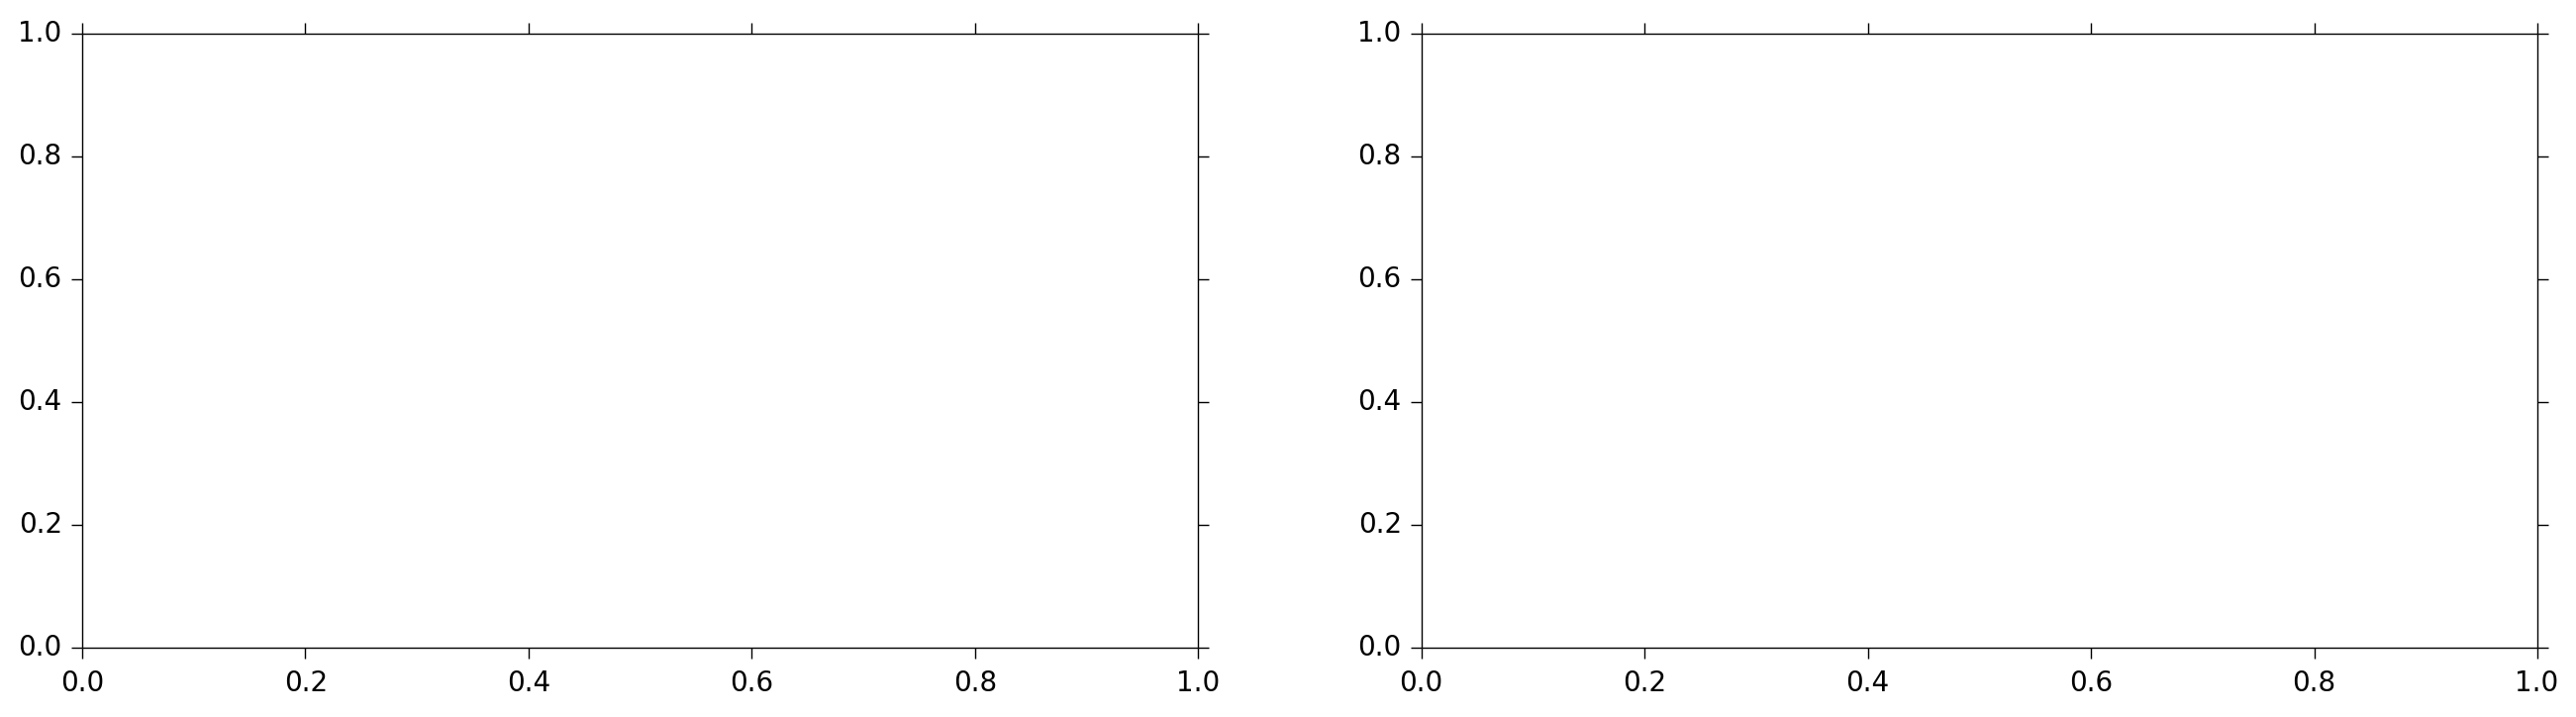

In [63]:
nms = ['Soil water 8.8-10.9%','Soil water 10.9-12.3%','Soil water 12.3-13.7%','Soil water 13.7-15.4%','Soil water 15.4-18.9%']
ok = ['AWC0877-1087', 'AWC1087-1230', 'AWC1230-1369', 'AWC1369-1539', 'AWC1539-1885']
for i in range(5):
    j = ok[i]
    fig, axs = plt.subplots(1,2)
    fig.set_figheight(4)
    fig.set_figwidth(16)
    
    ax1 = df.xs(('Y2008',j)).T.plot(ax=axs[0], legend=True, style=['gs-','yo-','r^-','yx-','k<-','bD-']);axs[0].set_title('Wet Summer (2008)')    
    patches1, labels1 = ax1.get_legend_handles_labels()
    ax1.legend(patches1, labels1, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.35), frameon=False)
    ax1.set_ylabel('Area (%)')
    ax1.set_xlabel('Temporal response (days)')
    
    ax2 = df.xs(('Y2009',j)).T.plot(ax=axs[1],legend=True, style=['gs-','yo-','r^-','yx-','k<-','bD-']);axs[1].set_title('Dry Summer (2009)')
    patches2, labels2 = ax2.get_legend_handles_labels()
    lgd = ax2.legend(patches1, labels1, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.35), frameon=False)
    ax2.set_ylabel('Area (%)')
    ax2.set_xlabel('Temporal response (days)')
    
    plt.suptitle(nms[i],fontsize=13)
    out_name = r'C:\Users\Matt\Documents\DELFT_products\decom\sm_awc_49_3//sm_awc_poster_'+j+'.png'    
    #fig.savefig(out_name, dpi=400, bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0.2)
    plt.show()

Decomposition based on Soil water

In [ ]:
#['AWC0877-1087', 'AWC1087-1230', 'AWC1230-1369', 'AWC1369-1539', 'AWC1539-1885'] 
fig, axs = plt.subplots(3,2)
fig.set_figheight(12)
fig.set_figwidth(16)
ax = df_org.xs(('Y2008','AWC0877-1087'), level=[0,1]).sum().plot(ax=axs[0,0],legend=False, color='blue', marker='s');axs[0,0].set_title('Soil water 8.8-10.9%')
ax = df_org.xs(('Y2009','AWC0877-1087'), level=[0,1]).sum().plot(ax=axs[0,0],legend=False, color='orange', marker='o')
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, ['Wet Year', 'Dry Year'], loc='best')

ax=df_org.xs(('Y2008','AWC1087-1230'), level=[0,1]).sum().plot(ax=axs[0,1],legend=False, color='blue', marker='s');axs[0,1].set_title('Soil water 10.9-12.3%')
ax=df_org.xs(('Y2009','AWC1087-1230'), level=[0,1]).sum().plot(ax=axs[0,1],legend=False, color='orange', marker='o')
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, ['Wet Year', 'Dry Year'], loc='best')

ax=df_org.xs(('Y2008','AWC1230-1369'), level=[0,1]).sum().plot(ax=axs[1,0],legend=False, color='blue', marker='s');axs[1,0].set_title('Soil water 12.3-13.7%')
ax=df_org.xs(('Y2009','AWC1230-1369'), level=[0,1]).sum().plot(ax=axs[1,0],legend=False, color='orange', marker='o')
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, ['Wet Year', 'Dry Year'], loc='best')

ax=df_org.xs(('Y2008','AWC1369-1539'), level=[0,1]).sum().plot(ax=axs[1,1],legend=False, color='blue', marker='s');axs[1,1].set_title('Soil water 13.7-15.4%')
ax=df_org.xs(('Y2009','AWC1369-1539'), level=[0,1]).sum().plot(ax=axs[1,1],legend=False, color='orange', marker='o')
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, ['Wet Year', 'Dry Year'], loc='best')

ax=df_org.xs(('Y2008','AWC1539-1885'), level=[0,1]).sum().plot(ax=axs[2,0],legend=False, color='blue', marker='s');axs[2,0].set_title('Soil water 15.4-18.9%')
ax=df_org.xs(('Y2009','AWC1539-1885'), level=[0,1]).sum().plot(ax=axs[2,0],legend=False, color='orange', marker='o')
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, ['Wet Year', 'Dry Year'], loc='best')

#ax=df_org.xs(('Y2008','water-6'), level=[0,2]).sum().plot(ax=axs[2,1],legend=False, color='blue', marker='s');axs[2,1].set_title('Water')
#ax=df_org.xs(('Y2009','water-6'), level=[0,2]).sum().plot(ax=axs[2,1],legend=False, color='orange', marker='o')
#patches, labels = ax.get_legend_handles_labels()
#ax.legend(patches, ['Wet Year', 'Dry Year'], loc='best')
fig.savefig(r'C:\Users\Matt\Documents\DELFT_products\decom//phase_decompose_soilwater_sm_awc_4_5.png', dpi=400)
plt.show()

In [ ]:
df2

In [ ]:
df_org.xs(('Y2008','AWC1539-1885'), level=[0,1]).sum()

In [ ]:
ax = df.plot(kind='bar', legend=False)
patches, labels = ax.get_legend_handles_labels()

ax.legend(patches, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)

In [ ]:
df_2

response time for same soil moisture class and landclass decomposed ABSOLUTE

In [ ]:
nms = ['Soil water 8.8-10.9%','Soil water 10.9-12.3%','Soil water 12.3-13.7%','Soil water 13.7-15.4%','Soil water 15.4-18.9%']
ok = ['AWC0877-1087', 'AWC1087-1230', 'AWC1230-1369', 'AWC1369-1539', 'AWC1539-1885']
for i in range(5):
    j = ok[i]
    fig, axs = plt.subplots(1,2)
    fig.set_figheight(4)
    fig.set_figwidth(16)
    df_org.xs(('Y2008',j)).T.plot(ax=axs[0],legend=True, style=['gs-','yo-','r^-','yx-','k<-','bD-']);axs[0].set_title('Wet Summer (2008)')
    df_org.xs(('Y2009',j)).T.plot(ax=axs[1],legend=True, style=['gs-','yo-','r^-','yx-','k<-','bD-']);axs[1].set_title('Dry Summer (2009)')
    plt.suptitle(nms[i],fontsize=13)
    out_name = r'C:\Users\Matt\Documents\DELFT_products\decom\sm_awc_49_3//sm_awc_49_3_'+j+'.png'
    #fig.savefig(out_name, dpi=400)
    plt.show()

Decomposition based on landclass

In [ ]:
fig, axs = plt.subplots(3,2)
fig.set_figheight(12)
fig.set_figwidth(16)
ax = df_org.xs(('Y2008','forest-1'), level=[0,2]).sum().plot(ax=axs[0,0],legend=False, color='blue', marker='s');axs[0,0].set_title('Forest')
ax = df_org.xs(('Y2009','forest-1'), level=[0,2]).sum().plot(ax=axs[0,0],legend=False, color='orange', marker='o')
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, ['Wet Year', 'Dry Year'], loc='best')

ax=df_org.xs(('Y2008','agricultland-2'), level=[0,2]).sum().plot(ax=axs[0,1],legend=False, color='blue', marker='s');axs[0,1].set_title('Agricultural land')
ax=df_org.xs(('Y2009','agricultland-2'), level=[0,2]).sum().plot(ax=axs[0,1],legend=False, color='orange', marker='o')
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, ['Wet Year', 'Dry Year'], loc='best')

ax=df_org.xs(('Y2008','artificalland-3'), level=[0,2]).sum().plot(ax=axs[1,0],legend=False, color='blue', marker='s');axs[1,0].set_title('Built-up')
ax=df_org.xs(('Y2009','artificalland-3'), level=[0,2]).sum().plot(ax=axs[1,0],legend=False, color='orange', marker='o')
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, ['Wet Year', 'Dry Year'], loc='best')

ax=df_org.xs(('Y2008','woodshrubs-4'), level=[0,2]).sum().plot(ax=axs[1,1],legend=False, color='blue', marker='s');axs[1,1].set_title('Shrubland')
ax=df_org.xs(('Y2009','woodshrubs-4'), level=[0,2]).sum().plot(ax=axs[1,1],legend=False, color='orange', marker='o')
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, ['Wet Year', 'Dry Year'], loc='best')

ax=df_org.xs(('Y2008','grassland-5'), level=[0,2]).sum().plot(ax=axs[2,0],legend=False, color='blue', marker='s');axs[2,0].set_title('Grassland')
ax=df_org.xs(('Y2009','grassland-5'), level=[0,2]).sum().plot(ax=axs[2,0],legend=False, color='orange', marker='o')
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, ['Wet Year', 'Dry Year'], loc='best')

ax=df_org.xs(('Y2008','water-6'), level=[0,2]).sum().plot(ax=axs[2,1],legend=False, color='blue', marker='s');axs[2,1].set_title('Water')
ax=df_org.xs(('Y2009','water-6'), level=[0,2]).sum().plot(ax=axs[2,1],legend=False, color='orange', marker='o')
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, ['Wet Year', 'Dry Year'], loc='best')
fig.savefig(r'C:\Users\Matt\Documents\DELFT_products//phase_decompose_landclass', dpi=400)
plt.show()



In [ ]:
awc_2008 = pd.read_csv(r'I:\DELFT_products\decom//2008_awc.csv', index_col='Y2008')
awc_2009 = pd.read_csv(r'I:\DELFT_products\decom//2009_awc.csv', index_col='Y2009')
awc_2008 *= 100
awc_2009 *= 100

fig, axs = plt.subplots(2,2)
fig.set_figheight(8)
fig.set_figwidth(16)

ax = awc_2008.T.plot(ax=axs[0,0], ylim=[0,50], legend=False, style=['o-', 's-', 'D-', '^-', '*-']);
axs[0,0].set_title('Wet summer')
axs[0,0].set_xlabel('Temporal response (days)')
axs[0,0].set_ylabel('Normalized area (%)')

patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, ['8.7-10.9', '10.9-12.3','12.3-13.7','13.7-15.4','15.4-18.9'], loc='best')

ax = awc_2009.T.plot(ax=axs[0,1], ylim=[0,50], legend=False, style=['o-', 's-', 'D-', '^-', '*-']);
axs[0,1].set_title('Dry summer')
axs[0,1].set_xlabel('Temporal response (days)')
axs[0,1].set_ylabel('Normalized area (%)')

patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, ['8.7-10.9', '10.9-12.3','12.3-13.7','13.7-15.4','15.4-18.9'], loc='best')


plt.savefig(r'I:\DELFT_products\decom//awc_phase.png', dpi=400)
plt.show()

In [ ]:
awc_2008 = pd.read_csv(r'I:\DELFT_products\decom//2008_landcover2.csv', index_col='Y2008')
awc_2009 = pd.read_csv(r'I:\DELFT_products\decom//2009_landcover2.csv', index_col='Y2009')
awc_2008 *= 100
awc_2009 *= 100

fig, axs = plt.subplots(2,2)
fig.set_figheight(8)
fig.set_figwidth(16)

ax = awc_2008.T.plot(ax=axs[0,0], ylim=[0,50], legend=False, style=['D-', 's-', 'o-', '^-', '*-']);
axs[0,0].set_title('Wet summer')
axs[0,0].set_xlabel('Temporal response (days)')
axs[0,0].set_ylabel('Normalized area (%)')

patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, ['Cropland','Forest','Grassland','Shrubland'], loc='best', numpoints=1)

ax = awc_2009.T.plot(ax=axs[0,1], ylim=[0,50], legend=False, style=['D-', 's-', 'o-', '^-', '*-']);
axs[0,1].set_title('Dry summer')
axs[0,1].set_xlabel('Temporal response (days)')
axs[0,1].set_ylabel('Normalized area (%)')

patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, ['Cropland','Forest','Grassland','Shrubland'], loc='best')

plt.savefig(r'I:\DELFT_products\decom//landcocer_phase.png', dpi=400)
plt.show()

In [ ]:
awc_2008